In [12]:
# In[1]: IMPORTS AND SETUP

import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# If you want to do time-series clustering with DTW:
# !pip install dtaidistance
from dtaidistance import dtw  # optional if we cluster with DTW

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

In [13]:
# In[2]: READ ALL COMMIT FILES

def load_commits_in_category(category="OSS"):
    """
    Returns a DataFrame with columns:
      ['project', 'contributor', 'commit_sha', 'commit_date', 'commit_message']
    from all_commits/<category>/<projectName>/<contributor>_commits.csv
    """
    base_dir = os.path.join("all_commits", category)
    rows = []
    # Each subfolder in base_dir = one project
    if not os.path.exists(base_dir):
        print(f"[WARN] No folder found for category: {category}")
        return pd.DataFrame()

    projects = sorted(os.listdir(base_dir))
    for proj in projects:
        proj_path = os.path.join(base_dir, proj)
        if not os.path.isdir(proj_path):
            continue
        # each file => one contributor
        csv_files = glob.glob(os.path.join(proj_path, "*_commits.csv"))
        for csvf in csv_files:
            contributor_name = os.path.basename(csvf).replace("_commits.csv", "")
            with open(csvf, "r", encoding="utf-8") as f:
                df_csv = pd.read_csv(csvf)
                # df_csv => columns: commit_sha, commit_date, commit_message, additions, ...
                for idx, row in df_csv.iterrows():
                    rows.append({
                        "project": proj,
                        "contributor": contributor_name,
                        "commit_sha": row["commit_sha"],
                        "commit_date": row["commit_date"],
                        "commit_message": row["commit_message"],
                        # we can ignore additions/deletions in this example
                    })
    return pd.DataFrame(rows)

df_oss = load_commits_in_category("OSS")
df_oss4sg = load_commits_in_category("OSS4SG")

print("OSS Commits:", len(df_oss))
print("OSS4SG Commits:", len(df_oss4sg))

# Combine them if needed
df_all = pd.concat([df_oss.assign(category="OSS"),
                    df_oss4sg.assign(category="OSS4SG")],
                   ignore_index=True)
print("Total Commits in Both:", len(df_all))

OSS Commits: 580144
OSS4SG Commits: 1639652
Total Commits in Both: 2219796


In [14]:
# In[3]: PROCESS DATES

df_all["commit_date"] = pd.to_datetime(df_all["commit_date"], utc=True, errors="coerce")
df_all = df_all.dropna(subset=["commit_date"])  # drop rows with invalid date
df_all = df_all.sort_values(by=["category", "project", "contributor", "commit_date"]).reset_index(drop=True)

df_all.head(5)


,project,contributor,commit_sha,commit_date,commit_message,category
0,BLCM_BLCMods,00Schmidt,f785bcfb275766c9c3ca3411c9b39a8dc77531e6,2017-03-12 04:21:04+00:00,Initial commit,OSS
1,BLCM_BLCMods,00Schmidt,64e40f9041202bc5f6e72e72f25fa319218a4f07,2017-03-12 18:27:08+00:00,Create Nemesis,OSS
2,BLCM_BLCMods,00Schmidt,a6a063eaa852db43a6f33ebf5173818f9336ccb1,2017-03-12 18:28:42+00:00,Create Nemesis No Slag,OSS
3,BLCM_BLCMods,00Schmidt,19aa1e8bf6cb38b4c04d58fbe4b39516a5de396e,2017-03-12 19:29:52+00:00,Delete Nemesis,OSS
4,BLCM_BLCMods,00Schmidt,dec930cfb26356baf68eb6314e0e569034c2c0cb,2017-03-12 19:31:19+00:00,Create Nemesis,OSS


/var/folders/f9/zgk8jdl15h32ccr4fy4qxmvm0000gn/T/ipykernel_7443/3223584179.py:3: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df_all["week"] = df_all["commit_date"].dt.to_period("W").apply(lambda r: r.start_time)


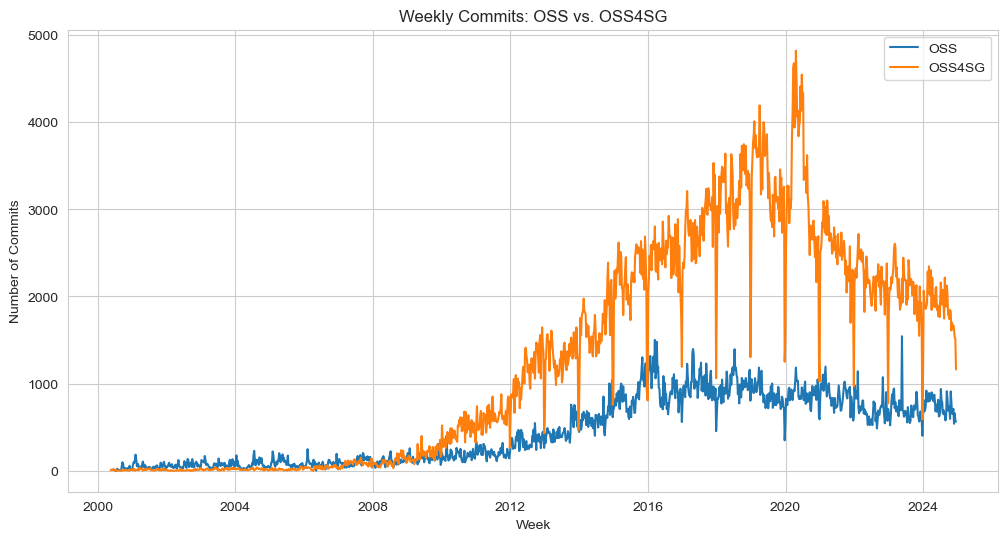

In [15]:
# In[4]: WEEKLY TIME SERIES

df_all["week"] = df_all["commit_date"].dt.to_period("W").apply(lambda r: r.start_time)

weekly_agg = (
    df_all.groupby(["category", "week"])
          .size()
          .reset_index(name="num_commits")
)

# Plot
plt.figure(figsize=(12,6))
for cat in ["OSS", "OSS4SG"]:
    subset = weekly_agg[weekly_agg["category"] == cat]
    plt.plot(subset["week"], subset["num_commits"], label=cat)

plt.title("Weekly Commits: OSS vs. OSS4SG")
plt.xlabel("Week")
plt.ylabel("Number of Commits")
plt.legend()
plt.show()

In [34]:
# In[5]: BUILD INDIVIDUAL TIME SERIES (WEEKLY) FOR EACH CONTRIBUTOR

df_all["week_period"] = df_all["commit_date"].dt.to_period("W")

def build_contributor_timeseries(df, category_filter=None):
    # optional: filter by category
    if category_filter:
        df = df[df["category"] == category_filter].copy()

    # group by (contributor, week) => number of commits
    ts = (df.groupby(["contributor", "week_period"])
            .size()
            .reset_index(name="num_commits"))
    # convert week_period to actual start date
    ts["week_start"] = ts["week_period"].apply(lambda r: r.start_time)
    return ts

ts_oss = build_contributor_timeseries(df_all, "OSS")
ts_oss4sg = build_contributor_timeseries(df_all, "OSS4SG")

ts_oss.head(10)
# In[6]: PLOT EXAMPLE CONTRIBUTOR

df_all["commit_msg_len"] = df_all["commit_message"].astype(str).apply(len)



/var/folders/f9/zgk8jdl15h32ccr4fy4qxmvm0000gn/T/ipykernel_7443/3378984854.py:3: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df_all["week_period"] = df_all["commit_date"].dt.to_period("W")


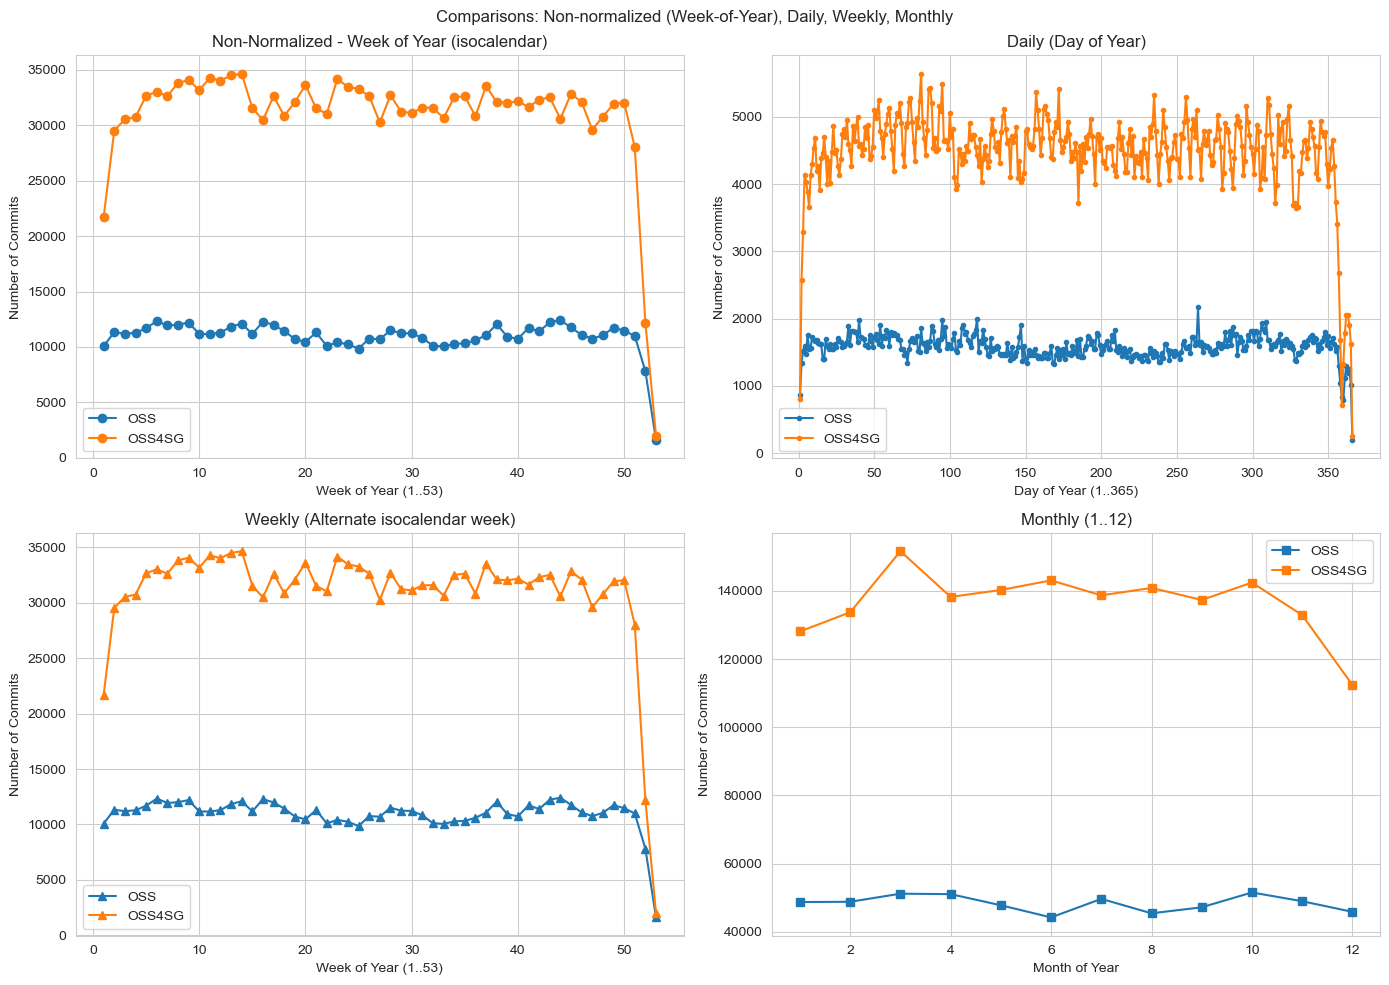

In [16]:
# In[4]: MULTIPLE PLOTS: NON-NORMALIZED VS. DAILY VS. WEEKLY VS. MONTHLY (FIXED dt.week ISSUE)

import matplotlib.pyplot as plt

# 1) Non-normalized "week of year" approach
df_all["week_of_year"] = df_all["commit_date"].dt.isocalendar().week  # 1..53

# Group by category + week_of_year => number of commits
weekly_agg_raw = ( 
    df_all.groupby(["category", "week_of_year"])
          .size()
          .reset_index(name="num_commits")
)

# 2) For daily: day_of_year
df_all["day_of_year"] = df_all["commit_date"].dt.dayofyear  # 1..365 (or 366)

daily_agg = (
    df_all.groupby(["category", "day_of_year"])
          .size()
          .reset_index(name="num_commits")
)

# 3) For weekly: we can demonstrate an alternative approach:
#    If you want a simpler 'week of year' index for a second demonstration,
#    let’s just reuse dt.isocalendar().week but name it 'week_alt' to differentiate.
df_all["week_alt"] = df_all["commit_date"].dt.isocalendar().week

weekly_agg = (
    df_all.groupby(["category", "week_alt"])
          .size()
          .reset_index(name="num_commits")
)

# 4) For monthly: month_of_year
df_all["month_of_year"] = df_all["commit_date"].dt.month  # 1..12

monthly_agg = (
    df_all.groupby(["category", "month_of_year"])
          .size()
          .reset_index(name="num_commits")
)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle("Comparisons: Non-normalized (Week-of-Year), Daily, Weekly, Monthly")

# --- Plot (1) Non-Normalized - week_of_year ---
ax1 = axes[0, 0]
for cat in ["OSS", "OSS4SG"]:
    subset = weekly_agg_raw[weekly_agg_raw["category"] == cat]
    ax1.plot(subset["week_of_year"], subset["num_commits"], label=cat, marker="o")
ax1.set_title("Non-Normalized - Week of Year (isocalendar)")
ax1.set_xlabel("Week of Year (1..53)")
ax1.set_ylabel("Number of Commits")
ax1.legend()

# --- Plot (2) Daily (day_of_year) ---
ax2 = axes[0, 1]
for cat in ["OSS", "OSS4SG"]:
    subset = daily_agg[daily_agg["category"] == cat]
    ax2.plot(subset["day_of_year"], subset["num_commits"], label=cat, marker=".")
ax2.set_title("Daily (Day of Year)")
ax2.set_xlabel("Day of Year (1..365)")
ax2.set_ylabel("Number of Commits")
ax2.legend()

# --- Plot (3) Weekly (week_alt) ---
ax3 = axes[1, 0]
for cat in ["OSS", "OSS4SG"]:
    subset = weekly_agg[weekly_agg["category"] == cat]
    ax3.plot(subset["week_alt"], subset["num_commits"], label=cat, marker="^")
ax3.set_title("Weekly (Alternate isocalendar week)")
ax3.set_xlabel("Week of Year (1..53)")
ax3.set_ylabel("Number of Commits")
ax3.legend()

# --- Plot (4) Monthly (month_of_year) ---
ax4 = axes[1, 1]
for cat in ["OSS", "OSS4SG"]:
    subset = monthly_agg[monthly_agg["category"] == cat]
    ax4.plot(subset["month_of_year"], subset["num_commits"], label=cat, marker="s")
ax4.set_title("Monthly (1..12)")
ax4.set_xlabel("Month of Year")
ax4.set_ylabel("Number of Commits")
ax4.legend()

plt.tight_layout()
plt.show()

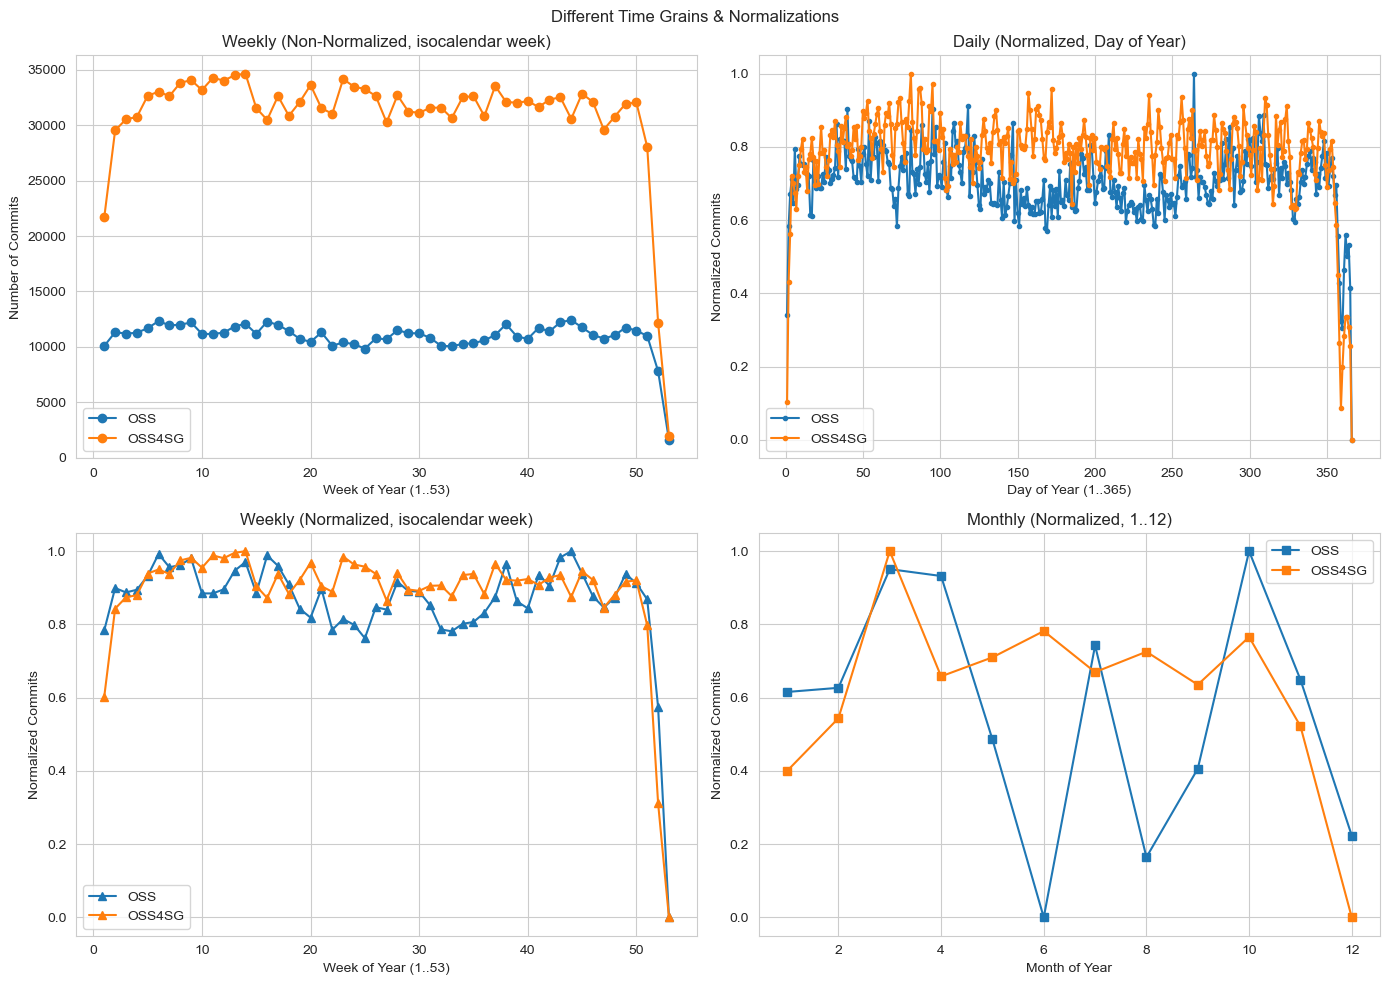

In [17]:
# In[4]: MULTIPLE PLOTS: 
#  (1) Weekly (Non-Normalized),
#  (2) Daily (Normalized),
#  (3) Weekly (Normalized),
#  (4) Monthly (Normalized)

import matplotlib.pyplot as plt

# 1) Non-normalized weekly (week_of_year) approach
df_all["week_of_year"] = df_all["commit_date"].dt.isocalendar().week  # 1..53

weekly_agg_raw = (
    df_all.groupby(["category", "week_of_year"])
          .size()
          .reset_index(name="num_commits")
)

# 2) Prepare daily (day_of_year) and normalize
df_all["day_of_year"] = df_all["commit_date"].dt.dayofyear  # 1..365
daily_agg = (
    df_all.groupby(["category", "day_of_year"])
          .size()
          .reset_index(name="num_commits")
)
daily_agg["normalized"] = 0.0
for cat in ["OSS", "OSS4SG"]:
    subset = daily_agg[daily_agg["category"] == cat]
    min_val = subset["num_commits"].min()
    max_val = subset["num_commits"].max()
    if max_val > min_val:
        norm_vals = (subset["num_commits"] - min_val) / (max_val - min_val)
    else:
        norm_vals = 0.0
    daily_agg.loc[daily_agg["category"] == cat, "normalized"] = norm_vals

# 3) Prepare an alternate weekly (isocalendar) and normalize
#    We'll reuse week_of_year or create a new 'week_alt'
df_all["week_alt"] = df_all["commit_date"].dt.isocalendar().week
weekly_agg_norm = (
    df_all.groupby(["category", "week_alt"])
          .size()
          .reset_index(name="num_commits")
)
weekly_agg_norm["normalized"] = 0.0
for cat in ["OSS", "OSS4SG"]:
    subset = weekly_agg_norm[weekly_agg_norm["category"] == cat]
    min_val = subset["num_commits"].min()
    max_val = subset["num_commits"].max()
    if max_val > min_val:
        norm_vals = (subset["num_commits"] - min_val) / (max_val - min_val)
    else:
        norm_vals = 0.0
    weekly_agg_norm.loc[weekly_agg_norm["category"] == cat, "normalized"] = norm_vals

# 4) Prepare monthly (month_of_year) and normalize
df_all["month_of_year"] = df_all["commit_date"].dt.month  # 1..12
monthly_agg = (
    df_all.groupby(["category", "month_of_year"])
          .size()
          .reset_index(name="num_commits")
)
monthly_agg["normalized"] = 0.0
for cat in ["OSS", "OSS4SG"]:
    subset = monthly_agg[monthly_agg["category"] == cat]
    min_val = subset["num_commits"].min()
    max_val = subset["num_commits"].max()
    if max_val > min_val:
        norm_vals = (subset["num_commits"] - min_val) / (max_val - min_val)
    else:
        norm_vals = 0.0
    monthly_agg.loc[monthly_agg["category"] == cat, "normalized"] = norm_vals

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle("Different Time Grains & Normalizations")

# (1) Non-Normalized Weekly (week_of_year)
ax1 = axes[0, 0]
for cat in ["OSS", "OSS4SG"]:
    sub = weekly_agg_raw[weekly_agg_raw["category"] == cat]
    ax1.plot(sub["week_of_year"], sub["num_commits"], label=cat, marker="o")
ax1.set_title("Weekly (Non-Normalized, isocalendar week)")
ax1.set_xlabel("Week of Year (1..53)")
ax1.set_ylabel("Number of Commits")
ax1.legend()

# (2) Daily (Normalized)
ax2 = axes[0, 1]
for cat in ["OSS", "OSS4SG"]:
    sub = daily_agg[daily_agg["category"] == cat]
    ax2.plot(sub["day_of_year"], sub["normalized"], label=cat, marker=".")
ax2.set_title("Daily (Normalized, Day of Year)")
ax2.set_xlabel("Day of Year (1..365)")
ax2.set_ylabel("Normalized Commits")
ax2.legend()

# (3) Weekly (Normalized)
ax3 = axes[1, 0]
for cat in ["OSS", "OSS4SG"]:
    sub = weekly_agg_norm[weekly_agg_norm["category"] == cat]
    ax3.plot(sub["week_alt"], sub["normalized"], label=cat, marker="^")
ax3.set_title("Weekly (Normalized, isocalendar week)")
ax3.set_xlabel("Week of Year (1..53)")
ax3.set_ylabel("Normalized Commits")
ax3.legend()

# (4) Monthly (Normalized)
ax4 = axes[1, 1]
for cat in ["OSS", "OSS4SG"]:
    sub = monthly_agg[monthly_agg["category"] == cat]
    ax4.plot(sub["month_of_year"], sub["normalized"], label=cat, marker="s")
ax4.set_title("Monthly (Normalized, 1..12)")
ax4.set_xlabel("Month of Year")
ax4.set_ylabel("Normalized Commits")
ax4.legend()

plt.tight_layout()
plt.show()

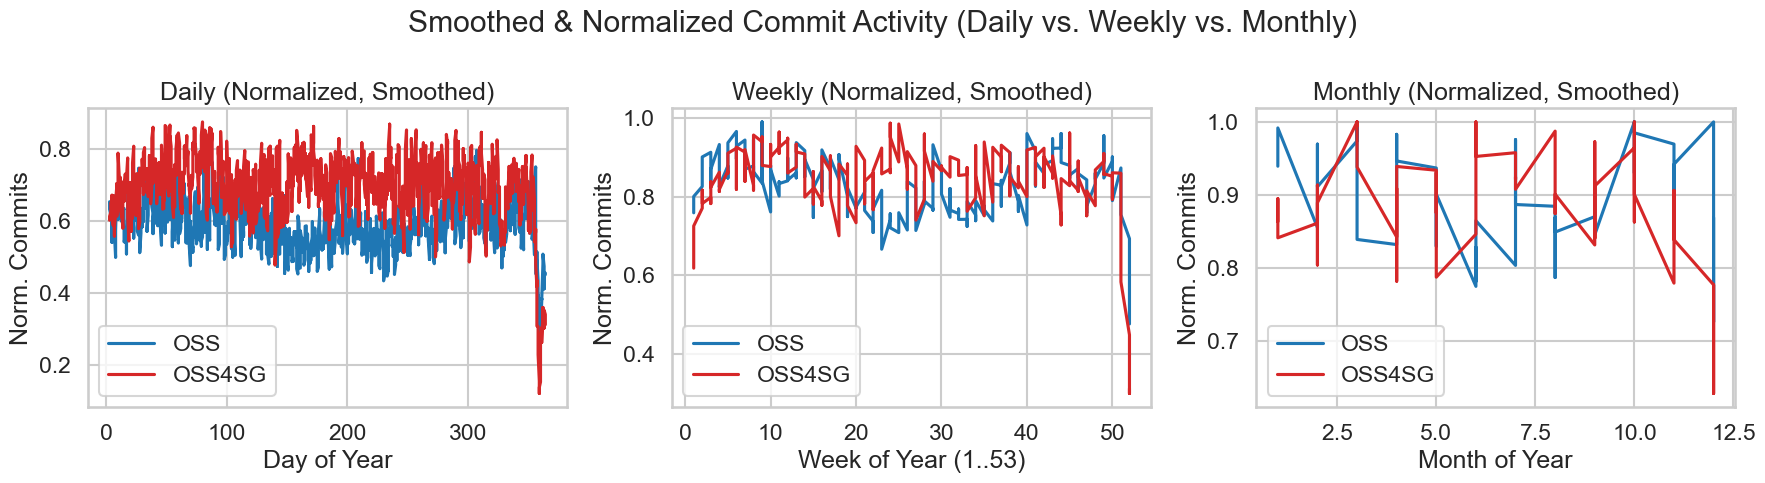

In [31]:
# --- PLOTTING ALL IN ONE FIGURE (SMOOTHED, EXCLUDING FIRST AND LAST VALUES) ---
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle("Smoothed & Normalized Commit Activity (Daily vs. Weekly vs. Monthly)")

# Helper function for smoothing with Savitzky-Golay
def smooth_curve(x_vals, y_vals, window=5, poly=2):
    # Ensure window length is odd and less than length of y_vals
    w_len = window if (len(y_vals) >= window and window % 2 == 1) else min(len(y_vals), 3)
    if w_len < 3:  # fallback if series is too short
        return y_vals
    return savgol_filter(y_vals, w_len, poly)

# 1) DAILY
ax1 = axes[0]
cat_colors = {"OSS": "#1f77b4", "OSS4SG": "#d62728"}  # example color mapping
for cat in ["OSS", "OSS4SG"]:
    sub = daily_agg[daily_agg["category"] == cat].copy()
    sub = sub.sort_values("day_of_year")
    sub = sub.iloc[10:-10]  # Exclude first and last values
    x = sub["day_of_year"].values
    y = sub["norm_commits"].values
    y_smooth = smooth_curve(x, y, window=7, poly=2)
    ax1.plot(x, y_smooth, label=cat, color=cat_colors[cat], marker="")
ax1.set_title("Daily (Normalized, Smoothed)")
ax1.set_xlabel("Day of Year")
ax1.set_ylabel("Norm. Commits")
ax1.legend()

# 2) WEEKLY
ax2 = axes[1]
for cat in ["OSS", "OSS4SG"]:
    sub = weekly_agg[weekly_agg["category"] == cat].copy()
    sub = sub.sort_values("week_of_year")
    sub = sub.iloc[1:-4]  # Exclude first and last values
    x = sub["week_of_year"].values
    y = sub["norm_commits"].values
    y_smooth = smooth_curve(x, y, window=5, poly=2)
    ax2.plot(x, y_smooth, label=cat, color=cat_colors[cat], marker="")
ax2.set_title("Weekly (Normalized, Smoothed)")
ax2.set_xlabel("Week of Year (1..53)")
ax2.set_ylabel("Norm. Commits")
ax2.legend()

# 3) MONTHLY
ax3 = axes[2]
for cat in ["OSS", "OSS4SG"]:
    sub = monthly_agg[monthly_agg["category"] == cat].copy()
    sub = sub.sort_values("month_of_year")
    sub = sub.iloc[1:-1]  # Exclude first and last values
    x = sub["month_of_year"].values
    y = sub["norm_commits"].values
    y_smooth = smooth_curve(x, y, window=3, poly=2)  # months only up to 12
    ax3.plot(x, y_smooth, label=cat, color=cat_colors[cat], marker="")
ax3.set_title("Monthly (Normalized, Smoothed)")
ax3.set_xlabel("Month of Year")
ax3.set_ylabel("Norm. Commits")
ax3.legend()

plt.tight_layout()
plt.show()


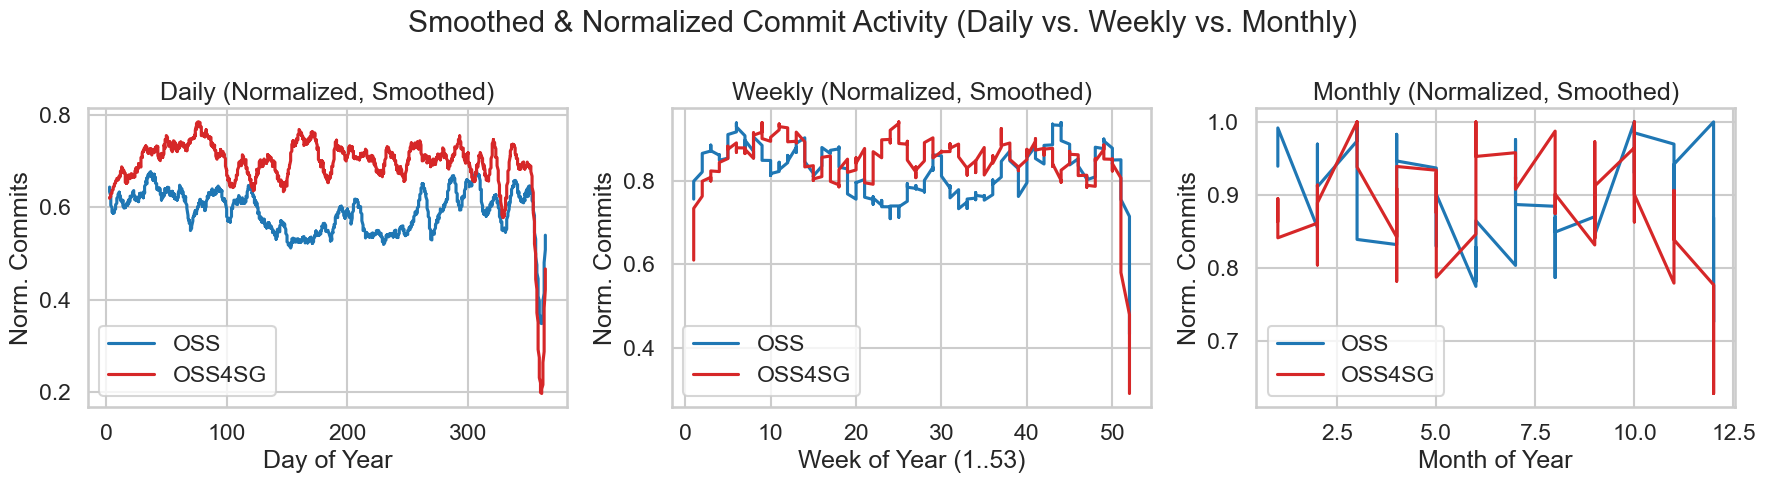

In [30]:
# --- PLOTTING ALL IN ONE FIGURE (SMOOTHED, EXCLUDING FIRST AND LAST VALUES) ---
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle("Smoothed & Normalized Commit Activity (Daily vs. Weekly vs. Monthly)")

# Helper function for smoothing with Savitzky-Golay
def smooth_curve(x_vals, y_vals, window=5, poly=2):
    # Ensure window length is odd and less than length of y_vals
    w_len = window if (len(y_vals) >= window and window % 2 == 1) else min(len(y_vals), 3)
    if w_len < 3:  # fallback if series is too short
        return y_vals
    return savgol_filter(y_vals, w_len, poly)

# 1) DAILY
ax1 = axes[0]
cat_colors = {"OSS": "#1f77b4", "OSS4SG": "#d62728"}  # example color mapping
for cat in ["OSS", "OSS4SG"]:
    sub = daily_agg[daily_agg["category"] == cat].copy()
    sub = sub.sort_values("day_of_year")
    sub = sub.iloc[10:-10]  # Exclude first and last values
    x = sub["day_of_year"].values
    y = sub["norm_commits"].values
    y_smooth = smooth_curve(x, y, window=51, poly=3)
    ax1.plot(x, y_smooth, label=cat, color=cat_colors[cat], marker="")
ax1.set_title("Daily (Normalized, Smoothed)")
ax1.set_xlabel("Day of Year")
ax1.set_ylabel("Norm. Commits")
ax1.legend()

# 2) WEEKLY
ax2 = axes[1]
for cat in ["OSS", "OSS4SG"]:
    sub = weekly_agg[weekly_agg["category"] == cat].copy()
    sub = sub.sort_values("week_of_year")
    sub = sub.iloc[1:-4]  # Exclude first and last values
    x = sub["week_of_year"].values
    y = sub["norm_commits"].values
    y_smooth = smooth_curve(x, y, window=11, poly=3)
    ax2.plot(x, y_smooth, label=cat, color=cat_colors[cat], marker="")
ax2.set_title("Weekly (Normalized, Smoothed)")
ax2.set_xlabel("Week of Year (1..53)")
ax2.set_ylabel("Norm. Commits")
ax2.legend()

# 3) MONTHLY
ax3 = axes[2]
for cat in ["OSS", "OSS4SG"]:
    sub = monthly_agg[monthly_agg["category"] == cat].copy()
    sub = sub.sort_values("month_of_year")
    sub = sub.iloc[1:-1]  # Exclude first and last values
    x = sub["month_of_year"].values
    y = sub["norm_commits"].values
    y_smooth = smooth_curve(x, y, window=3, poly=2)  # months only up to 12
    ax3.plot(x, y_smooth, label=cat, color=cat_colors[cat], marker="")
ax3.set_title("Monthly (Normalized, Smoothed)")
ax3.set_xlabel("Month of Year")
ax3.set_ylabel("Norm. Commits")
ax3.legend()

plt.tight_layout()
plt.show()


In [27]:
# Count core and non-core contributors per category (OSS, OSS4SG)
category_core_counts = (
    df_all.groupby(["category", "is_core"])["contributor"]
    .nunique()
    .reset_index(name="num_contributors")
)

# Separate core and non-core counts for each category
oss_core = category_core_counts[
    (category_core_counts["category"] == "OSS") & (category_core_counts["is_core"] == True)
]["num_contributors"].sum()

oss_non_core = category_core_counts[
    (category_core_counts["category"] == "OSS") & (category_core_counts["is_core"] == False)
]["num_contributors"].sum()

oss4sg_core = category_core_counts[
    (category_core_counts["category"] == "OSS4SG") & (category_core_counts["is_core"] == True)
]["num_contributors"].sum()

oss4sg_non_core = category_core_counts[
    (category_core_counts["category"] == "OSS4SG") & (category_core_counts["is_core"] == False)
]["num_contributors"].sum()

print(f"OSS Core Contributors: {oss_core}")
print(f"OSS Non-Core Contributors: {oss_non_core}")
print(f"OSS4SG Core Contributors: {oss4sg_core}")
print(f"OSS4SG Non-Core Contributors: {oss4sg_non_core}")


OSS Core Contributors: 739
OSS Non-Core Contributors: 10095
OSS4SG Core Contributors: 975
OSS4SG Non-Core Contributors: 9066


In [36]:
# In[6]: IDENTIFY CORE CONTRIBUTORS (80% COMMITS) & COMPARE AVERAGE COMMIT MESSAGE LENGTH

import numpy as np
df_all["commit_length"] = df_all["commit_message"].astype(str).apply(len)

# 1) Group by (project, contributor) to find total commits per contributor within each project
df_contrib_totals = (
    df_all.groupby(["project", "contributor"])
          .size()
          .reset_index(name="commit_count")
)

# 2) For each project, sort contributors by commit_count desc,
#    compute cumulative sum, and mark core if they pass 80% threshold.
core_map = {}  # (project, contributor) -> is_core (True/False)

projects = df_contrib_totals["project"].unique()
for proj in projects:
    sub = df_contrib_totals[df_contrib_totals["project"] == proj].copy()
    total_commits = sub["commit_count"].sum()
    sub = sub.sort_values("commit_count", ascending=False).reset_index(drop=True)
    sub["cumsum"] = sub["commit_count"].cumsum()

    # Mark as core if cumsum <= 0.8 * total_commits
    threshold = 0.8 * total_commits
    sub["is_core"] = sub["cumsum"] <= threshold
    
    # Store in core_map
    for idx, row in sub.iterrows():
        pc = (proj, row["contributor"])
        core_map[pc] = bool(row["is_core"])

# 3) Create a column in df_all that says if the contributor is core or not
def is_core_func(row):
    # row: project, contributor
    project = row["project"]
    contrib = row["contributor"]
    return core_map.get((project, contrib), False)

df_all["is_core"] = df_all.apply(is_core_func, axis=1)

# 4) We already have "commit_length"
#    Now let's compare average commit_length for (category, is_core)
compare_df = (
    df_all.groupby(["category", "is_core"])["commit_length"]
          .mean()
          .reset_index(name="avg_commit_length")
)

print(compare_df)

# OPTIONAL: You might want to pivot for easier reading:
pivot_table = compare_df.pivot(index="category", columns="is_core", values="avg_commit_length")
print("\nPivoted Table:\n", pivot_table)

  category  is_core  avg_commit_length
0      OSS    False         145.862253
1      OSS     True         155.893271
2   OSS4SG    False         114.236125
3   OSS4SG     True         100.046098

Pivoted Table:
 is_core        False       True 
category                        
OSS       145.862253  155.893271
OSS4SG    114.236125  100.046098


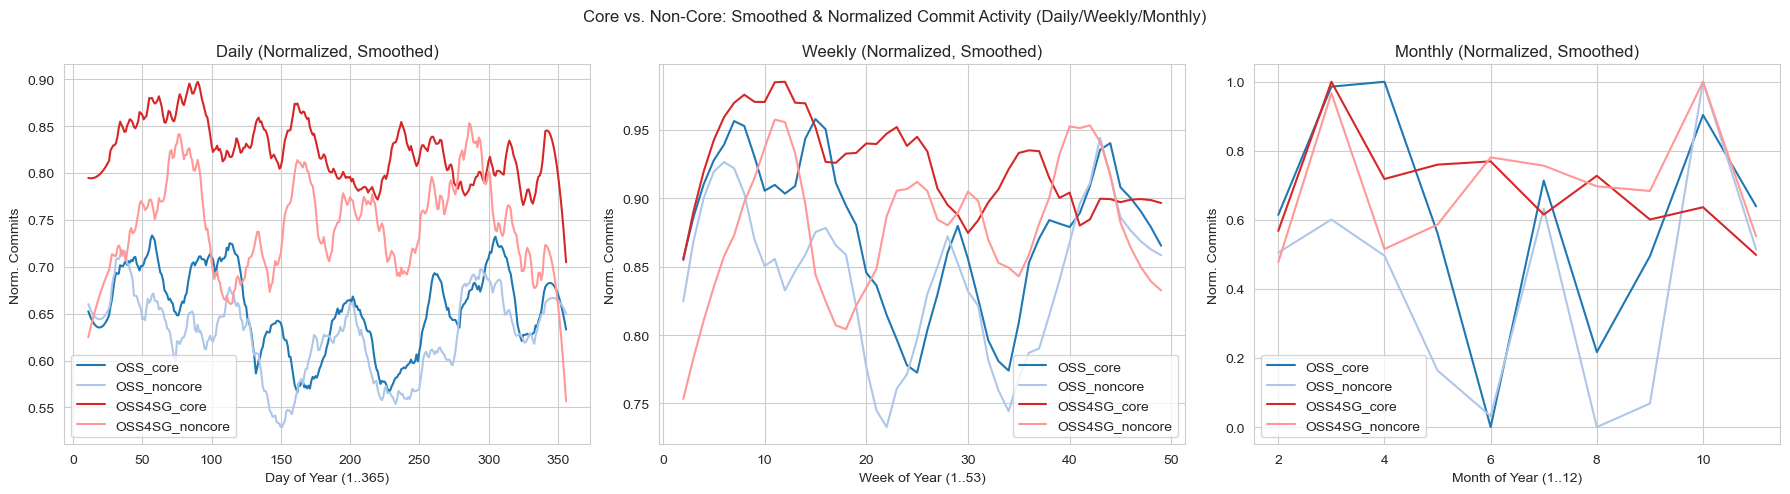

In [20]:
# In[7]: PREPARE DATAFRAMES (daily_agg, weekly_agg, monthly_agg) WITH is_core INCLUDED
#        THEN PLOT THEM (SMOOTHED, NORMALIZED) FOR THE 4 GROUPS:
#        1) OSS Core, 2) OSS Non-Core, 3) OSS4SG Core, 4) OSS4SG Non-Core

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.signal import savgol_filter

plt.rcParams["figure.figsize"] = (18,5)

# 1) We'll group df_all by day_of_year, week_of_year, month_of_year
#    but now we also include 'is_core' in the grouping.
#    Then we min-max normalize num_commits *within each group of (category, is_core).

# Ensure df_all has the following columns:
#   - commit_date (datetime)
#   - category in ["OSS","OSS4SG"]
#   - is_core (True/False)
#   - project, contributor, etc.
# We'll create daily_agg, weekly_agg, monthly_agg with columns:
#   [category, is_core, day_of_year / week_of_year / month_of_year, num_commits, norm_commits]

# DAILY
df_all["day_of_year"] = df_all["commit_date"].dt.dayofyear  # 1..365 or 366

daily_agg = (
    df_all.groupby(["category","is_core","day_of_year"])
          .size()
          .reset_index(name="num_commits")
)

daily_agg["norm_commits"] = 0.0
for (cat_core), subdf in daily_agg.groupby(["category","is_core"]):
    idx = subdf.index
    vmin = subdf["num_commits"].min()
    vmax = subdf["num_commits"].max()
    if vmax > vmin:
        daily_agg.loc[idx, "norm_commits"] = (subdf["num_commits"] - vmin)/(vmax - vmin)
    else:
        daily_agg.loc[idx, "norm_commits"] = 0.0

# WEEKLY (Using isocalendar().week)
df_all["week_of_year"] = df_all["commit_date"].dt.isocalendar().week  # 1..53

weekly_agg = (
    df_all.groupby(["category","is_core","week_of_year"])
          .size()
          .reset_index(name="num_commits")
)

weekly_agg["norm_commits"] = 0.0
for (cat_core), subdf in weekly_agg.groupby(["category","is_core"]):
    idx = subdf.index
    vmin = subdf["num_commits"].min()
    vmax = subdf["num_commits"].max()
    if vmax > vmin:
        weekly_agg.loc[idx, "norm_commits"] = (subdf["num_commits"] - vmin)/(vmax - vmin)
    else:
        weekly_agg.loc[idx, "norm_commits"] = 0.0

# MONTHLY
df_all["month_of_year"] = df_all["commit_date"].dt.month  # 1..12

monthly_agg = (
    df_all.groupby(["category","is_core","month_of_year"])
          .size()
          .reset_index(name="num_commits")
)

monthly_agg["norm_commits"] = 0.0
for (cat_core), subdf in monthly_agg.groupby(["category","is_core"]):
    idx = subdf.index
    vmin = subdf["num_commits"].min()
    vmax = subdf["num_commits"].max()
    if vmax > vmin:
        monthly_agg.loc[idx, "norm_commits"] = (subdf["num_commits"] - vmin)/(vmax - vmin)
    else:
        monthly_agg.loc[idx, "norm_commits"] = 0.0

# 2) Create combined label for easier plotting: "OSS_core", "OSS_noncore", "OSS4SG_core", "OSS4SG_noncore"
def combine_cat_core(row):
    base = row["category"]
    return base + ("_core" if row["is_core"] else "_noncore")

daily_agg["cat_core"]   = daily_agg.apply(combine_cat_core, axis=1)
weekly_agg["cat_core"]  = weekly_agg.apply(combine_cat_core, axis=1)
monthly_agg["cat_core"] = monthly_agg.apply(combine_cat_core, axis=1)

# 3) Let's plot them similarly to your example: Daily, Weekly, Monthly in one figure,
#    smoothed & normalized. We'll exclude first/last points as you indicated.

def smooth_curve(x_vals, y_vals, window=5, poly=2):
    w_len = window if (len(y_vals) >= window and window % 2 == 1) else min(len(y_vals), 3)
    if w_len < 3:
        return y_vals
    return savgol_filter(y_vals, w_len, poly)

fig, axes = plt.subplots(1, 3, figsize=(18,5))
fig.suptitle("Core vs. Non-Core: Smoothed & Normalized Commit Activity (Daily/Weekly/Monthly)")

# Custom colors for 4 lines
cat_colors = {
    "OSS_core":    "#1f77b4",
    "OSS_noncore": "#aec7e8",
    "OSS4SG_core": "#d62728",
    "OSS4SG_noncore": "#ff9896"
}

# A) DAILY
ax1 = axes[0]
for cat_core in ["OSS_core","OSS_noncore","OSS4SG_core","OSS4SG_noncore"]:
    sub = daily_agg[daily_agg["cat_core"] == cat_core].copy()
    sub = sub.sort_values("day_of_year")
    # Exclude first/last if desired
    if len(sub) > 2:
        sub = sub.iloc[10:-10]
    x = sub["day_of_year"].values
    y = sub["norm_commits"].values
    # pick window for smoothing
    window_size = 31 if len(y) >= 31 else 5
    y_smooth = smooth_curve(x, y, window=window_size, poly=2)
    ax1.plot(x, y_smooth, label=cat_core, color=cat_colors[cat_core], marker="")
ax1.set_title("Daily (Normalized, Smoothed)")
ax1.set_xlabel("Day of Year (1..365)")
ax1.set_ylabel("Norm. Commits")
ax1.legend()

# B) WEEKLY
ax2 = axes[1]
for cat_core in ["OSS_core","OSS_noncore","OSS4SG_core","OSS4SG_noncore"]:
    sub = weekly_agg[weekly_agg["cat_core"] == cat_core].copy()
    sub = sub.sort_values("week_of_year")
    if len(sub) > 5:
        sub = sub.iloc[1:-4]
    x = sub["week_of_year"].values
    y = sub["norm_commits"].values
    window_size = 9 if len(y) >= 9 else 3
    y_smooth = smooth_curve(x, y, window=window_size, poly=2)
    ax2.plot(x, y_smooth, label=cat_core, color=cat_colors[cat_core], marker="")
ax2.set_title("Weekly (Normalized, Smoothed)")
ax2.set_xlabel("Week of Year (1..53)")
ax2.set_ylabel("Norm. Commits")
ax2.legend()

# C) MONTHLY
ax3 = axes[2]
for cat_core in ["OSS_core","OSS_noncore","OSS4SG_core","OSS4SG_noncore"]:
    sub = monthly_agg[monthly_agg["cat_core"] == cat_core].copy()
    sub = sub.sort_values("month_of_year")
    if len(sub) > 2:
        sub = sub.iloc[1:-1]
    x = sub["month_of_year"].values
    y = sub["norm_commits"].values
    window_size = 3 if len(y) >= 3 else 1
    y_smooth = smooth_curve(x, y, window=window_size, poly=2)
    ax3.plot(x, y_smooth, label=cat_core, color=cat_colors[cat_core], marker="")
ax3.set_title("Monthly (Normalized, Smoothed)")
ax3.set_xlabel("Month of Year (1..12)")
ax3.set_ylabel("Norm. Commits")
ax3.legend()

plt.tight_layout()
plt.show()

In [21]:
# Count core and non-core contributors per project
core_counts = df_all.groupby(["project", "is_core"])["contributor"].nunique().reset_index(name="num_contributors")

# Aggregate total core and non-core contributors
total_core = core_counts[core_counts["is_core"] == True]["num_contributors"].sum()
total_non_core = core_counts[core_counts["is_core"] == False]["num_contributors"].sum()

print(f"Total Core Contributors: {total_core}")
print(f"Total Non-Core Contributors: {total_non_core}")


Total Core Contributors: 2529
Total Non-Core Contributors: 25139


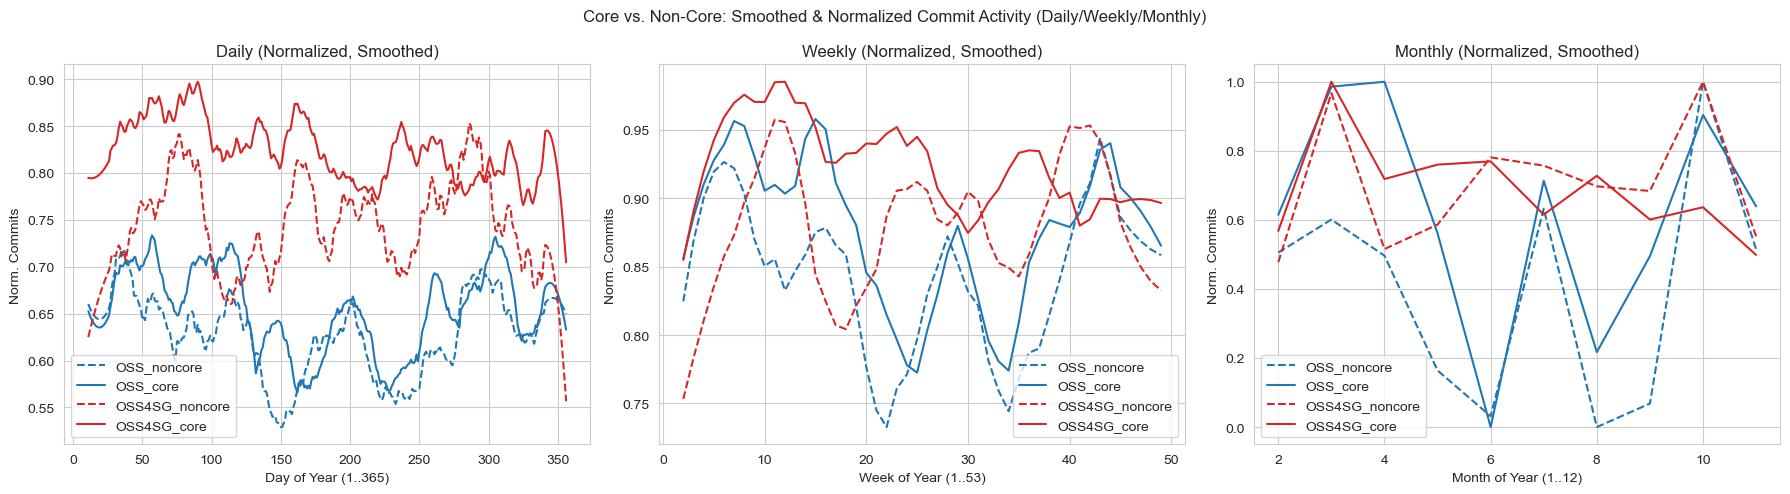

In [22]:
# In[4]: MULTIPLE PLOTS (Daily, Weekly, Monthly) with 4 Lines:
#         OSS_core (solid), OSS_noncore (dashed),
#         OSS4SG_core (solid), OSS4SG_noncore (dashed).

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.signal import savgol_filter

plt.rcParams["figure.figsize"] = (18,5)

def smooth_curve(x_vals, y_vals, window=5, poly=2):
    """
    Apply Savitzky-Golay filtering to smooth the data.
    Ensure window length is odd and <= len(y_vals).
    """
    w_len = window if (len(y_vals) >= window and window % 2 == 1) else min(len(y_vals), 3)
    if w_len < 3:
        return y_vals
    return savgol_filter(y_vals, w_len, poly)

# We'll define color mapping and line styles for 4 lines:
cat_colors = {
    ("OSS", True):    "#1f77b4",  # OSS_core -> solid
    ("OSS", False):   "#1f77b4",  # OSS_noncore -> dashed but same color
    ("OSS4SG", True): "#d62728",  # OSS4SG_core -> solid
    ("OSS4SG", False):"#d62728",  # OSS4SG_noncore -> dashed
}

cat_styles = {
    ("OSS", True):    "-",   # core => solid
    ("OSS", False):   "--",  # non-core => dashed
    ("OSS4SG", True): "-",   # core => solid
    ("OSS4SG", False):"--",  # non-core => dashed
}

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle("Core vs. Non-Core: Smoothed & Normalized Commit Activity (Daily/Weekly/Monthly)")

# 1) DAILY
ax1 = axes[0]
groups_daily = daily_agg.groupby(["category","is_core"])
for (cat, iscore), sub in groups_daily:
    sub = sub.sort_values("day_of_year").copy()
    # Optional: exclude first/last row to avoid edge artifacts
    if len(sub) > 2:
        sub = sub.iloc[10:-10]

    x = sub["day_of_year"].values
    y = sub["norm_commits"].values

    # Smoothing
    window_size = 31 if len(y) >= 31 else 5
    y_smooth = smooth_curve(x, y, window=window_size, poly=2)

    # Plot
    label_str = f"{cat}_{'core' if iscore else 'noncore'}"
    color_val = cat_colors[(cat, iscore)]
    style_val = cat_styles[(cat, iscore)]
    ax1.plot(x, y_smooth, label=label_str, color=color_val, linestyle=style_val)

ax1.set_title("Daily (Normalized, Smoothed)")
ax1.set_xlabel("Day of Year (1..365)")
ax1.set_ylabel("Norm. Commits")
ax1.legend()

# 2) WEEKLY
ax2 = axes[1]
groups_weekly = weekly_agg.groupby(["category","is_core"])
for (cat, iscore), sub in groups_weekly:
    sub = sub.sort_values("week_of_year").copy()
    if len(sub) > 5:
        sub = sub.iloc[1:-4]

    x = sub["week_of_year"].values
    y = sub["norm_commits"].values

    window_size = 9 if len(y) >= 9 else 3
    y_smooth = smooth_curve(x, y, window=window_size, poly=2)

    label_str = f"{cat}_{'core' if iscore else 'noncore'}"
    color_val = cat_colors[(cat, iscore)]
    style_val = cat_styles[(cat, iscore)]
    ax2.plot(x, y_smooth, label=label_str, color=color_val, linestyle=style_val)

ax2.set_title("Weekly (Normalized, Smoothed)")
ax2.set_xlabel("Week of Year (1..53)")
ax2.set_ylabel("Norm. Commits")
ax2.legend()

# 3) MONTHLY
ax3 = axes[2]
groups_monthly = monthly_agg.groupby(["category","is_core"])
for (cat, iscore), sub in groups_monthly:
    sub = sub.sort_values("month_of_year").copy()
    if len(sub) > 2:
        sub = sub.iloc[1:-1]

    x = sub["month_of_year"].values
    y = sub["norm_commits"].values

    window_size = 3 if len(y) >= 3 else 1
    y_smooth = smooth_curve(x, y, window=window_size, poly=2)

    label_str = f"{cat}_{'core' if iscore else 'noncore'}"
    color_val = cat_colors[(cat, iscore)]
    style_val = cat_styles[(cat, iscore)]
    ax3.plot(x, y_smooth, label=label_str, color=color_val, linestyle=style_val)

ax3.set_title("Monthly (Normalized, Smoothed)")
ax3.set_xlabel("Month of Year (1..12)")
ax3.set_ylabel("Norm. Commits")
ax3.legend()

plt.tight_layout()
plt.show()

In [ ]:
df_all.head()

OSS Commits: 580144
OSS4SG Commits: 1639652
Combined Commits in df_all: 2219796


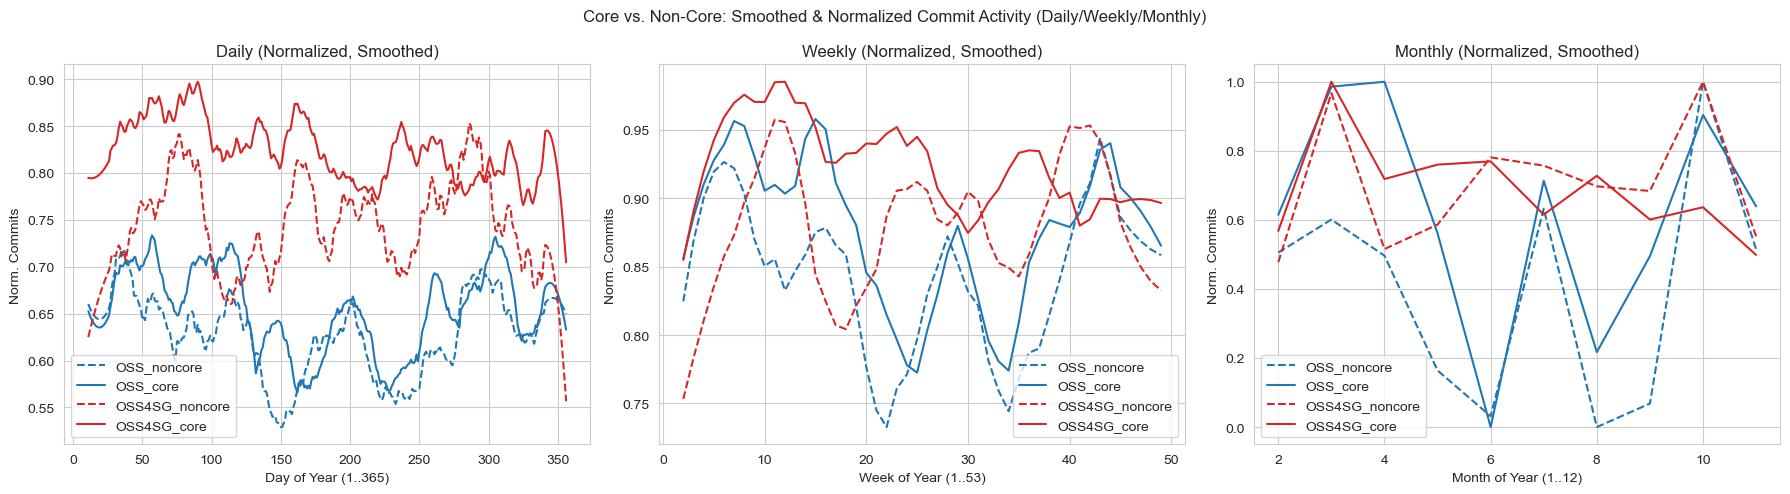

In [23]:
# In[1]: LOAD DATA FROM SCRATCH, IDENTIFY CORE CONTRIBUTORS, NORMALIZE (Daily/Weekly/Monthly), THEN PLOT

import os
import glob
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import savgol_filter

##############################################################################
# 1) LOAD COMMIT DATA FROM FOLDERS all_commits/OSS/ and all_commits/OSS4SG/
##############################################################################

def load_commits_in_category(category="OSS"):
    """
    Returns a DataFrame with columns:
      ['project', 'contributor', 'commit_sha', 'commit_date', 'commit_message']
    from all_commits/<category>/<projectName>/<contributor>_commits.csv
    """
    base_dir = os.path.join("all_commits", category)
    rows = []
    if not os.path.exists(base_dir):
        print(f"[WARN] No folder found for category: {category}")
        return pd.DataFrame()

    projects = sorted(os.listdir(base_dir))
    for proj in projects:
        proj_path = os.path.join(base_dir, proj)
        if not os.path.isdir(proj_path):
            continue
        csv_files = glob.glob(os.path.join(proj_path, "*_commits.csv"))
        for csvf in csv_files:
            contributor_name = os.path.basename(csvf).replace("_commits.csv", "")
            df_csv = pd.read_csv(csvf, encoding="utf-8")
            for _, row in df_csv.iterrows():
                rows.append({
                    "project": proj,
                    "contributor": contributor_name,
                    "commit_sha": row["commit_sha"],
                    "commit_date": row["commit_date"],
                    "commit_message": row["commit_message"],
                })
    return pd.DataFrame(rows)

df_oss    = load_commits_in_category("OSS")
df_oss4sg = load_commits_in_category("OSS4SG")

df_all = pd.concat([df_oss.assign(category="OSS"),
                    df_oss4sg.assign(category="OSS4SG")],
                   ignore_index=True)

print("OSS Commits:", len(df_oss))
print("OSS4SG Commits:", len(df_oss4sg))
print("Combined Commits in df_all:", len(df_all))

##############################################################################
# 2) IDENTIFY CORE CONTRIBUTORS (80% COMMITS) PER PROJECT
##############################################################################

# Convert commit_date to datetime
df_all["commit_date"] = pd.to_datetime(df_all["commit_date"], errors="coerce", utc=True)
df_all = df_all.dropna(subset=["commit_date"]).reset_index(drop=True)

# Count commits per (project, contributor)
df_contrib_count = (
    df_all.groupby(["project", "contributor"])
          .size()
          .reset_index(name="commit_count")
)

core_map = {}  # (project, contributor) -> bool is_core

for proj in df_contrib_count["project"].unique():
    sub = df_contrib_count[df_contrib_count["project"] == proj].copy()
    total_commits = sub["commit_count"].sum()
    sub = sub.sort_values("commit_count", ascending=False).reset_index(drop=True)
    sub["cumsum"] = sub["commit_count"].cumsum()
    threshold = 0.8 * total_commits
    sub["is_core"] = sub["cumsum"] <= threshold
    for idx, row in sub.iterrows():
        pc = (proj, row["contributor"])
        core_map[pc] = bool(row["is_core"])

def is_core_func(row):
    return core_map.get((row["project"], row["contributor"]), False)

df_all["is_core"] = df_all.apply(is_core_func, axis=1)

##############################################################################
# 3) BUILD DAILY, WEEKLY, MONTHLY AGG & MIN-MAX NORMALIZE (category + is_core)
##############################################################################

df_all["day_of_year"] = df_all["commit_date"].dt.dayofyear  # 1..365 or 366
df_all["week_of_year"] = df_all["commit_date"].dt.isocalendar().week  # 1..53
df_all["month_of_year"] = df_all["commit_date"].dt.month

# (A) DAILY
daily_agg = (
    df_all.groupby(["category","is_core","day_of_year"])
          .size()
          .reset_index(name="num_commits")
)

daily_agg["norm_commits"] = 0.0
for (cat, core), subdf in daily_agg.groupby(["category","is_core"]):
    idx = subdf.index
    vmin = subdf["num_commits"].min()
    vmax = subdf["num_commits"].max()
    if vmax > vmin:
        daily_agg.loc[idx, "norm_commits"] = (subdf["num_commits"] - vmin)/(vmax - vmin)
    else:
        daily_agg.loc[idx, "norm_commits"] = 0.0

# (B) WEEKLY
weekly_agg = (
    df_all.groupby(["category","is_core","week_of_year"])
          .size()
          .reset_index(name="num_commits")
)

weekly_agg["norm_commits"] = 0.0
for (cat, core), subdf in weekly_agg.groupby(["category","is_core"]):
    idx = subdf.index
    vmin = subdf["num_commits"].min()
    vmax = subdf["num_commits"].max()
    if vmax > vmin:
        weekly_agg.loc[idx, "norm_commits"] = (subdf["num_commits"] - vmin)/(vmax - vmin)
    else:
        weekly_agg.loc[idx, "norm_commits"] = 0.0

# (C) MONTHLY
monthly_agg = (
    df_all.groupby(["category","is_core","month_of_year"])
          .size()
          .reset_index(name="num_commits")
)

monthly_agg["norm_commits"] = 0.0
for (cat, core), subdf in monthly_agg.groupby(["category","is_core"]):
    idx = subdf.index
    vmin = subdf["num_commits"].min()
    vmax = subdf["num_commits"].max()
    if vmax > vmin:
        monthly_agg.loc[idx, "norm_commits"] = (subdf["num_commits"] - vmin)/(vmax - vmin)
    else:
        monthly_agg.loc[idx, "norm_commits"] = 0.0

##############################################################################
# 4) PLOT ALL 4 LINES: (OSS_core, OSS_noncore, OSS4SG_core, OSS4SG_noncore)
##############################################################################

def smooth_curve(x_vals, y_vals, window=5, poly=2):
    w_len = window if (len(y_vals) >= window and window % 2 == 1) else min(len(y_vals), 3)
    if w_len < 3:
        return y_vals
    return savgol_filter(y_vals, w_len, poly)

cat_colors = {
    ("OSS", True):    "#1f77b4",  # solid
    ("OSS", False):   "#1f77b4",  # dashed
    ("OSS4SG", True): "#d62728",  # solid
    ("OSS4SG", False):"#d62728",  # dashed
}
cat_styles = {
    ("OSS", True):    "-",
    ("OSS", False):   "--",
    ("OSS4SG", True): "-",
    ("OSS4SG", False):"--",
}

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle("Core vs. Non-Core: Smoothed & Normalized Commit Activity (Daily/Weekly/Monthly)")

# (1) DAILY
ax1 = axes[0]
groups_daily = daily_agg.groupby(["category","is_core"])
for (cat, iscore), sub in groups_daily:
    sub = sub.sort_values("day_of_year").copy()
    # optional exclude first/last rows if big enough
    if len(sub) > 20:
        sub = sub.iloc[10:-10]

    x = sub["day_of_year"].values
    y = sub["norm_commits"].values
    window_size = 31 if len(y) >= 31 else 5
    y_smooth = smooth_curve(x, y, window=window_size, poly=2)

    label_str = f"{cat}_{'core' if iscore else 'noncore'}"
    color_val = cat_colors[(cat, iscore)]
    style_val = cat_styles[(cat, iscore)]
    ax1.plot(x, y_smooth, label=label_str, color=color_val, linestyle=style_val)

ax1.set_title("Daily (Normalized, Smoothed)")
ax1.set_xlabel("Day of Year (1..365)")
ax1.set_ylabel("Norm. Commits")
ax1.legend()

# (2) WEEKLY
ax2 = axes[1]
groups_weekly = weekly_agg.groupby(["category","is_core"])
for (cat, iscore), sub in groups_weekly:
    sub = sub.sort_values("week_of_year").copy()
    if len(sub) > 5:
        sub = sub.iloc[1:-4]

    x = sub["week_of_year"].values
    y = sub["norm_commits"].values
    window_size = 9 if len(y) >= 9 else 3
    y_smooth = smooth_curve(x, y, window=window_size, poly=2)

    label_str = f"{cat}_{'core' if iscore else 'noncore'}"
    color_val = cat_colors[(cat, iscore)]
    style_val = cat_styles[(cat, iscore)]
    ax2.plot(x, y_smooth, label=label_str, color=color_val, linestyle=style_val)

ax2.set_title("Weekly (Normalized, Smoothed)")
ax2.set_xlabel("Week of Year (1..53)")
ax2.set_ylabel("Norm. Commits")
ax2.legend()

# (3) MONTHLY
ax3 = axes[2]
groups_monthly = monthly_agg.groupby(["category","is_core"])
for (cat, iscore), sub in groups_monthly:
    sub = sub.sort_values("month_of_year").copy()
    if len(sub) > 2:
        sub = sub.iloc[1:-1]

    x = sub["month_of_year"].values
    y = sub["norm_commits"].values
    window_size = 3 if len(y) >= 3 else 1
    y_smooth = smooth_curve(x, y, window=window_size, poly=2)

    label_str = f"{cat}_{'core' if iscore else 'noncore'}"
    color_val = cat_colors[(cat, iscore)]
    style_val = cat_styles[(cat, iscore)]
    ax3.plot(x, y_smooth, label=label_str, color=color_val, linestyle=style_val)

ax3.set_title("Monthly (Normalized, Smoothed)")
ax3.set_xlabel("Month of Year (1..12)")
ax3.set_ylabel("Norm. Commits")
ax3.legend()

plt.tight_layout()
plt.show()

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Paths to your CSV files
early_csv = '/Users/mohamadashraf/Downloads/OSS4SG_MSR-main-2/Datasets/GraphInfo/Join Rate vs Leave Rate for early stages.csv'
mid_csv = '/Users/mohamadashraf/Downloads/OSS4SG_MSR-main-2/Datasets/GraphInfo/Join Rate vs Leave Rate for mid stages.csv'
late_csv = '/Users/mohamadashraf/Downloads/OSS4SG_MSR-main-2/Datasets/GraphInfo/Join Rate vs Leave Rate for late stages.csv'

# Read the CSV files
df_early = pd.read_csv(early_csv)
df_mid = pd.read_csv(mid_csv)
df_late = pd.read_csv(late_csv)

# Add 'Stage' column
df_early['Stage'] = 'Early'
df_mid['Stage'] = 'Mid'
df_late['Stage'] = 'Late'

# Combine all dataframes
df_all_projects = pd.concat([df_early, df_mid, df_late], ignore_index=True)

# Set up plotting style
sns.set_style("whitegrid")
sns.set_context("talk")

In [25]:
df_all_projects

,Repo,SG,Average Leave Rate,Average Join Rate,Stage
0,OpenFarm,1,0.196310,0.201495,Early
1,openfoodfacts-androidapp,1,0.312722,0.334167,Early
2,electricitymaps-contrib,1,0.287571,0.376735,Early
3,onadata,1,0.126905,0.130106,Early
4,udata,1,0.165529,0.205542,Early
...,...,...,...,...,...
430,backbone.marionette,0,0.071429,0.071429,Late
431,build-web-application-with-golang,0,0.309524,0.166667,Late
432,bootswatch,0,0.238095,0.238095,Late
433,s3cmd,0,0.459184,0.459184,Late


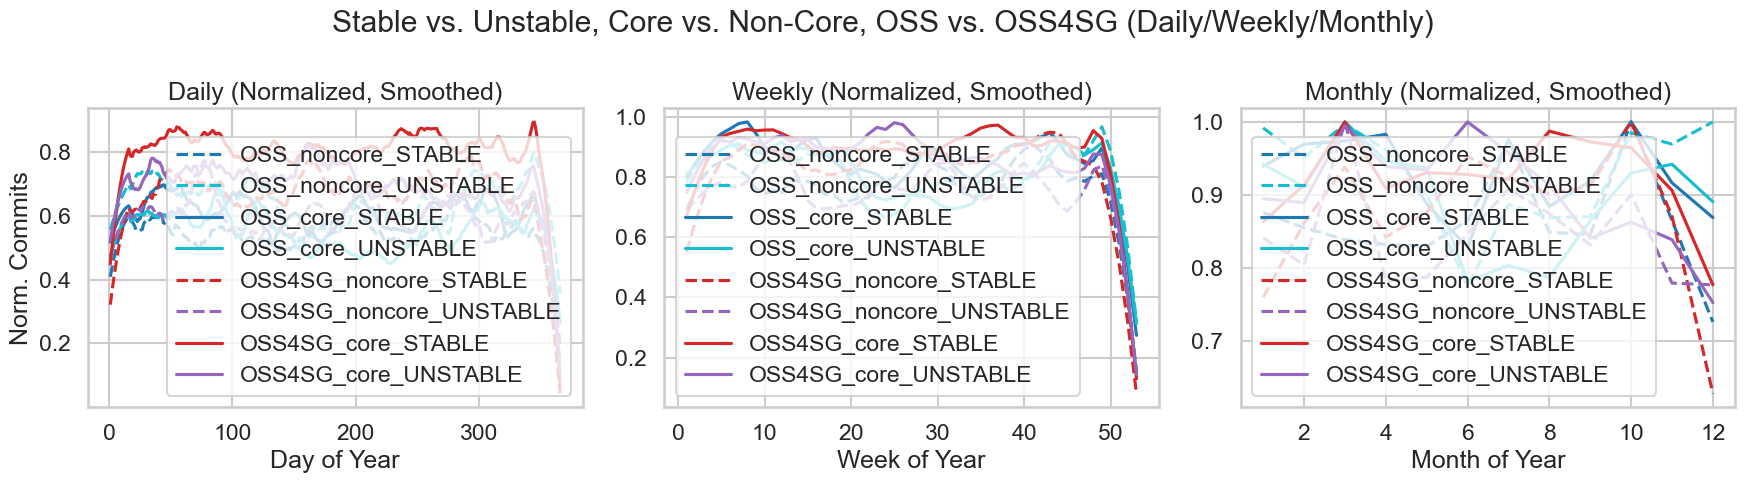

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

# Median thresholds
JOIN_THRESHOLD = 0.182
LEAVE_THRESHOLD = 0.164

# 1. Classify Projects as Stable or Unstable
def classify_stability(row):
    if row["Average Join Rate"] < JOIN_THRESHOLD and row["Average Leave Rate"] < LEAVE_THRESHOLD:
        return "STABLE"
    else:
        return "UNSTABLE"

df_all_projects["stability"] = df_all_projects.apply(classify_stability, axis=1)

# 2. Map Stability to df_all
def map_stability(project_name):
    repo_name = project_name.split("_")[-1]  # Extract the repo name
    stability_row = df_all_projects[df_all_projects["Repo"].str.lower() == repo_name.lower()]
    return stability_row["stability"].values[0] if not stability_row.empty else None

df_all["stability"] = df_all["project"].apply(map_stability)

# Drop rows where stability could not be determined
df_all = df_all.dropna(subset=["stability"])

# 3. Aggregation by Time
# Daily Aggregation
daily_agg = (
    df_all.groupby(["category", "is_core", "stability", "day_of_year"])
          .size()
          .reset_index(name="num_commits")
)
daily_agg["norm_commits"] = daily_agg.groupby(["category", "is_core", "stability"])["num_commits"].transform(lambda x: x / x.max())

# Weekly Aggregation
weekly_agg = (
    df_all.groupby(["category", "is_core", "stability", "week_of_year"])
          .size()
          .reset_index(name="num_commits")
)
weekly_agg["norm_commits"] = weekly_agg.groupby(["category", "is_core", "stability"])["num_commits"].transform(lambda x: x / x.max())

# Monthly Aggregation
monthly_agg = (
    df_all.groupby(["category", "is_core", "stability", "month_of_year"])
          .size()
          .reset_index(name="num_commits")
)
monthly_agg["norm_commits"] = monthly_agg.groupby(["category", "is_core", "stability"])["num_commits"].transform(lambda x: x / x.max())

# 4. Plotting
plt.rcParams["figure.figsize"] = (18, 5)

def smooth_curve(x_vals, y_vals, window=5, poly=2):
    w_len = window if (len(y_vals) >= window and window % 2 == 1) else min(len(y_vals), 3)
    return savgol_filter(y_vals, w_len, poly) if w_len >= 3 else y_vals

fig, axes = plt.subplots(1, 3)
fig.suptitle("Stable vs. Unstable, Core vs. Non-Core, OSS vs. OSS4SG (Daily/Weekly/Monthly)")

# Define color mapping and line styles
line_config = {
    ("OSS", True, "STABLE"):    {"color": "#1f77b4", "linestyle": "-"},   # OSS_core_stable
    ("OSS", False, "STABLE"):   {"color": "#1f77b4", "linestyle": "--"},  # OSS_noncore_stable
    ("OSS4SG", True, "STABLE"): {"color": "#d62728", "linestyle": "-"},   # OSS4SG_core_stable
    ("OSS4SG", False, "STABLE"):{"color": "#d62728", "linestyle": "--"},  # OSS4SG_noncore_stable
    ("OSS", True, "UNSTABLE"):  {"color": "#17becf", "linestyle": "-"},   # OSS_core_unstable
    ("OSS", False, "UNSTABLE"): {"color": "#17becf", "linestyle": "--"},  # OSS_noncore_unstable
    ("OSS4SG", True, "UNSTABLE"):{"color": "#9467bd", "linestyle": "-"},  # OSS4SG_core_unstable
    ("OSS4SG", False, "UNSTABLE"):{"color": "#9467bd", "linestyle": "--"} # OSS4SG_noncore_unstable
}

# Daily
ax1 = axes[0]
groups_daily = daily_agg.groupby(["category", "is_core", "stability"])
for (cat, is_core, stab), sub in groups_daily:
    x = sub["day_of_year"].values
    y = sub["norm_commits"].values
    y_smooth = smooth_curve(x, y, window=31, poly=2)
    config = line_config[(cat, is_core, stab)]
    ax1.plot(x, y_smooth, label=f"{cat}_{'core' if is_core else 'noncore'}_{stab}", **config)
ax1.set_title("Daily (Normalized, Smoothed)")
ax1.set_xlabel("Day of Year")
ax1.set_ylabel("Norm. Commits")
ax1.legend()

# Weekly
ax2 = axes[1]
groups_weekly = weekly_agg.groupby(["category", "is_core", "stability"])
for (cat, is_core, stab), sub in groups_weekly:
    x = sub["week_of_year"].values
    y = sub["norm_commits"].values
    y_smooth = smooth_curve(x, y, window=9, poly=2)
    config = line_config[(cat, is_core, stab)]
    ax2.plot(x, y_smooth, label=f"{cat}_{'core' if is_core else 'noncore'}_{stab}", **config)
ax2.set_title("Weekly (Normalized, Smoothed)")
ax2.set_xlabel("Week of Year")
ax2.legend()

# Monthly
ax3 = axes[2]
groups_monthly = monthly_agg.groupby(["category", "is_core", "stability"])
for (cat, is_core, stab), sub in groups_monthly:
    x = sub["month_of_year"].values
    y = sub["norm_commits"].values
    y_smooth = smooth_curve(x, y, window=3, poly=2)
    config = line_config[(cat, is_core, stab)]
    ax3.plot(x, y_smooth, label=f"{cat}_{'core' if is_core else 'noncore'}_{stab}", **config)
ax3.set_title("Monthly (Normalized, Smoothed)")
ax3.set_xlabel("Month of Year")
ax3.legend()

plt.tight_layout()
plt.show()

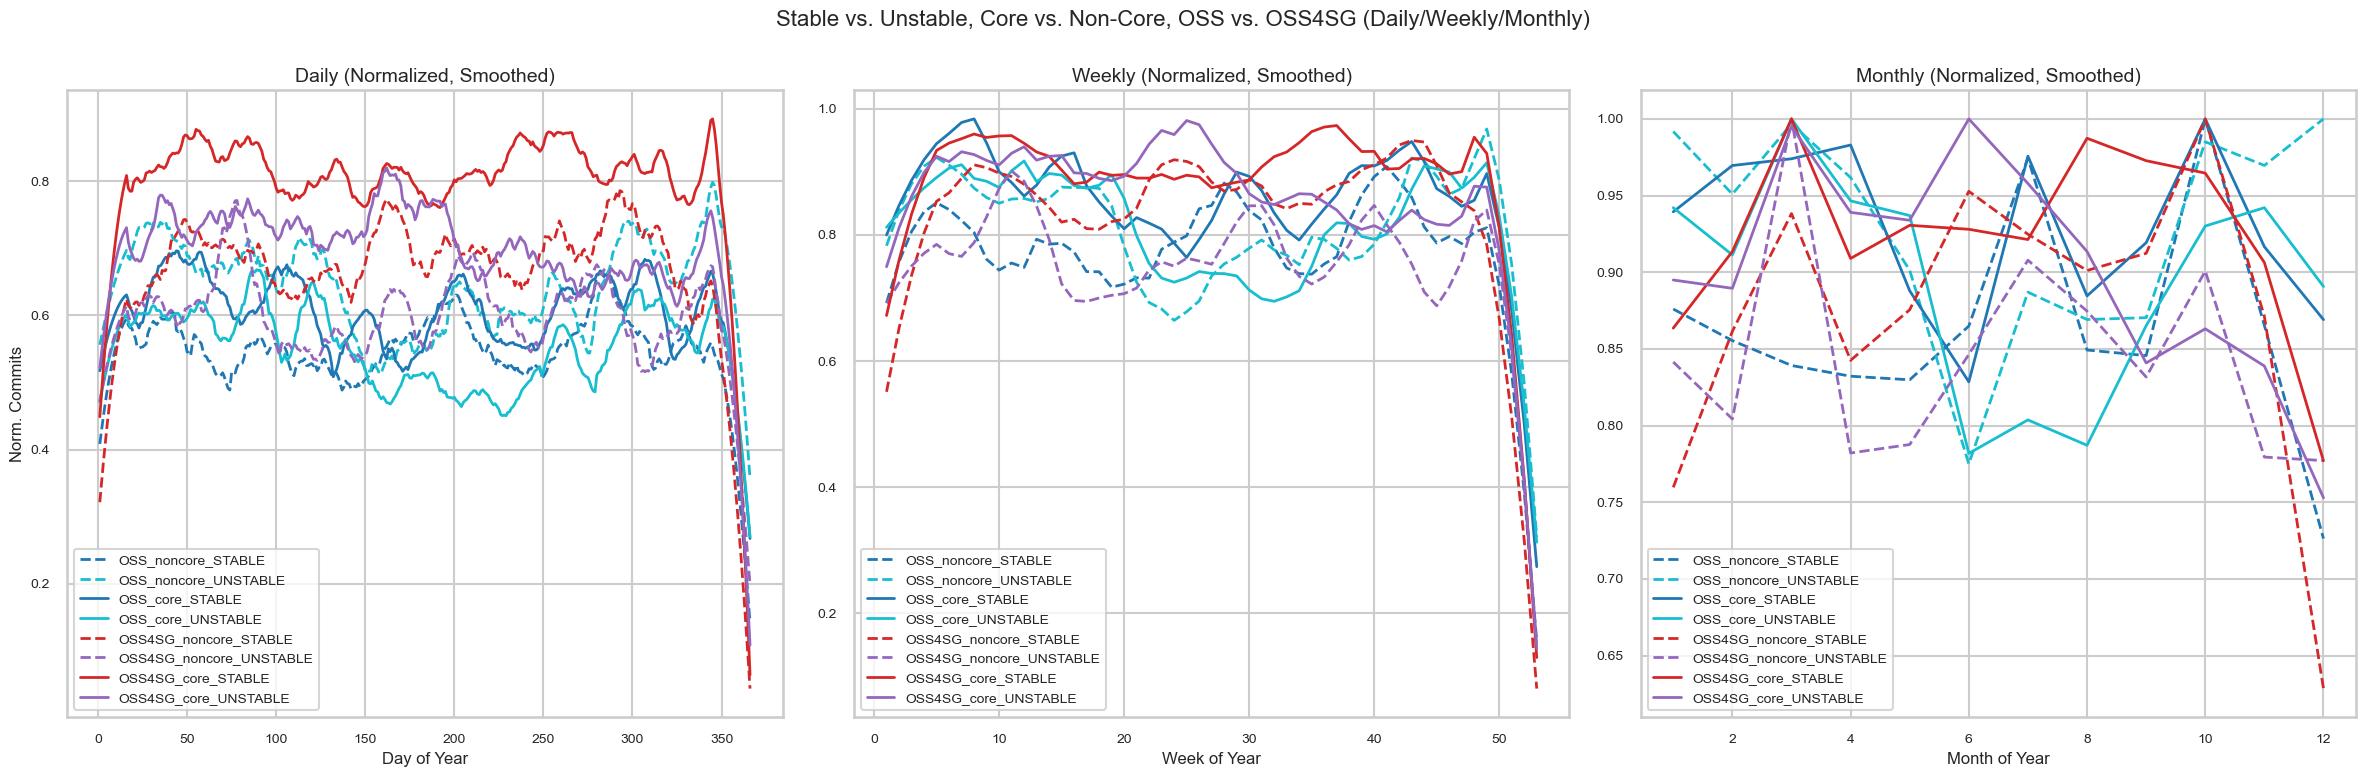

In [68]:
# 4. Plotting
plt.rcParams["figure.figsize"] = (24, 8)  # Increased from (18, 5)

def smooth_curve(x_vals, y_vals, window=5, poly=2):
    w_len = window if (len(y_vals) >= window and window % 2 == 1) else min(len(y_vals), 3)
    return savgol_filter(y_vals, w_len, poly) if w_len >= 3 else y_vals

fig, axes = plt.subplots(1, 3, figsize=(24, 8))  # Explicitly set figure size here too
fig.suptitle("Stable vs. Unstable, Core vs. Non-Core, OSS vs. OSS4SG (Daily/Weekly/Monthly)", fontsize=16)  # Increased font size

# Define color mapping and line styles
line_config = {
    ("OSS", True, "STABLE"):    {"color": "#1f77b4", "linestyle": "-", "linewidth": 2},   # Added linewidth
    ("OSS", False, "STABLE"):   {"color": "#1f77b4", "linestyle": "--", "linewidth": 2},
    ("OSS4SG", True, "STABLE"): {"color": "#d62728", "linestyle": "-", "linewidth": 2},
    ("OSS4SG", False, "STABLE"):{"color": "#d62728", "linestyle": "--", "linewidth": 2},
    ("OSS", True, "UNSTABLE"):  {"color": "#17becf", "linestyle": "-", "linewidth": 2},
    ("OSS", False, "UNSTABLE"): {"color": "#17becf", "linestyle": "--", "linewidth": 2},
    ("OSS4SG", True, "UNSTABLE"):{"color": "#9467bd", "linestyle": "-", "linewidth": 2},
    ("OSS4SG", False, "UNSTABLE"):{"color": "#9467bd", "linestyle": "--", "linewidth": 2}
}

# Daily
ax1 = axes[0]
groups_daily = daily_agg.groupby(["category", "is_core", "stability"])
for (cat, is_core, stab), sub in groups_daily:
    x = sub["day_of_year"].values
    y = sub["norm_commits"].values
    y_smooth = smooth_curve(x, y, window=31, poly=2)
    config = line_config[(cat, is_core, stab)]
    ax1.plot(x, y_smooth, label=f"{cat}_{'core' if is_core else 'noncore'}_{stab}", **config)
ax1.set_title("Daily (Normalized, Smoothed)", fontsize=14)
ax1.set_xlabel("Day of Year", fontsize=12)
ax1.set_ylabel("Norm. Commits", fontsize=12)
ax1.legend(fontsize=10)
ax1.tick_params(axis='both', labelsize=10)

# Weekly
ax2 = axes[1]
groups_weekly = weekly_agg.groupby(["category", "is_core", "stability"])
for (cat, is_core, stab), sub in groups_weekly:
    x = sub["week_of_year"].values
    y = sub["norm_commits"].values
    y_smooth = smooth_curve(x, y, window=9, poly=2)
    config = line_config[(cat, is_core, stab)]
    ax2.plot(x, y_smooth, label=f"{cat}_{'core' if is_core else 'noncore'}_{stab}", **config)
ax2.set_title("Weekly (Normalized, Smoothed)", fontsize=14)
ax2.set_xlabel("Week of Year", fontsize=12)
ax2.legend(fontsize=10)
ax2.tick_params(axis='both', labelsize=10)

# Monthly
ax3 = axes[2]
groups_monthly = monthly_agg.groupby(["category", "is_core", "stability"])
for (cat, is_core, stab), sub in groups_monthly:
    x = sub["month_of_year"].values
    y = sub["norm_commits"].values
    y_smooth = smooth_curve(x, y, window=3, poly=2)
    config = line_config[(cat, is_core, stab)]
    ax3.plot(x, y_smooth, label=f"{cat}_{'core' if is_core else 'noncore'}_{stab}", **config)
ax3.set_title("Monthly (Normalized, Smoothed)", fontsize=14)
ax3.set_xlabel("Month of Year", fontsize=12)
ax3.legend(fontsize=10)
ax3.tick_params(axis='both', labelsize=10)

plt.tight_layout()
plt.show()

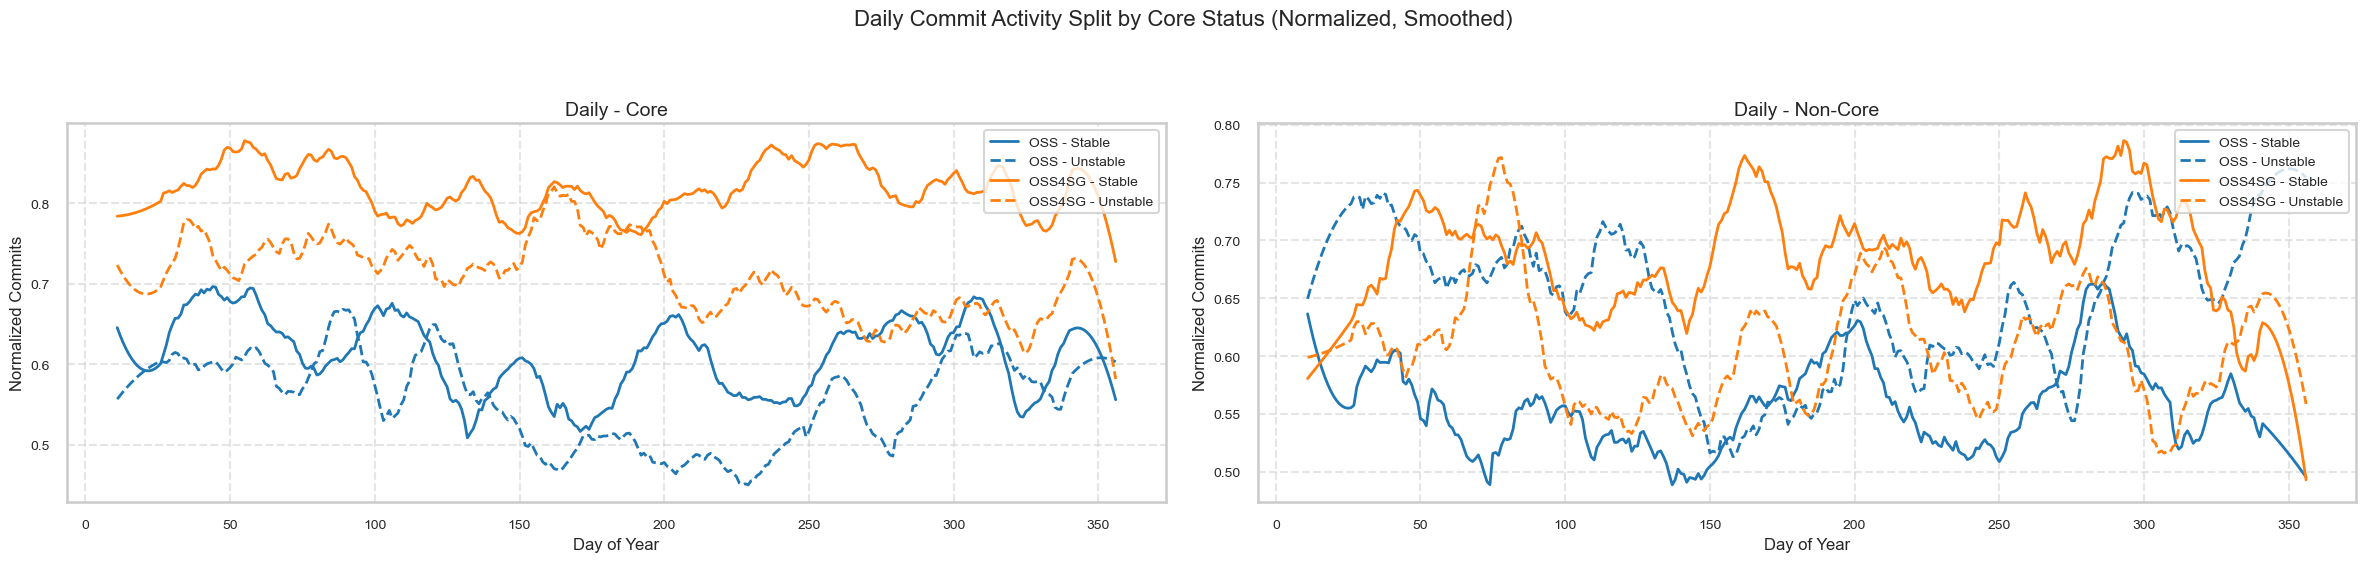

In [91]:
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
import pandas as pd

# Assuming daily_agg is your aggregated daily DataFrame
# Example structure of daily_agg:
# daily_agg = pd.DataFrame({
#     'category': [...],
#     'is_core': [...],      # Boolean: True or False
#     'stability': [...],    # "STABLE" or "UNSTABLE"
#     'day_of_year': [...],
#     'norm_commits': [...]
# })

# 1. Data Preparation: Remove the first and last 10 days
def trim_data(df, days_to_trim=10):
    max_day = df['day_of_year'].max()
    return df[(df['day_of_year'] > days_to_trim) & (df['day_of_year'] <= (max_day - days_to_trim))]

# Split the data into Core and Non-Core
core_data = daily_agg[daily_agg["is_core"] == True]
noncore_data = daily_agg[daily_agg["is_core"] == False]

# Trim both Core and Non-Core data
core_data_trimmed = trim_data(core_data)
noncore_data_trimmed = trim_data(noncore_data)

# 2. Plotting Daily Data Split by 'is_core'
plt.rcParams["figure.figsize"] = (24, 6)  # Increased width for two subplots

def smooth_curve(x_vals, y_vals, window=5, poly=2):
    w_len = window if (len(y_vals) >= window and window % 2 == 1) else min(len(y_vals), 3)
    return savgol_filter(y_vals, w_len, poly) if w_len >= 3 else y_vals

# Define color mapping based on 'category'
color_mapping = {
    "OSS": "#1f77b4",      # Blue
    "OSS4SG": "#ff7f0e"    # Orange
}

# Define line style mapping based on 'stability'
line_style_mapping = {
    "STABLE": "-",
    "UNSTABLE": "--"
}

# Create two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(24, 6))
fig.suptitle("Daily Commit Activity Split by Core Status (Normalized, Smoothed)", fontsize=16)

# Function to plot data on a given axis
def plot_data(ax, data, is_core_label):
    groups = data.groupby(["category", "stability"])
    for (cat, stab), sub in groups:
        x = sub["day_of_year"].values
        y = sub["norm_commits"].values
        y_smooth = smooth_curve(x, y, window=31, poly=2)
        
        color = color_mapping.get(cat, "grey")
        linestyle = line_style_mapping.get(stab, "-")
        
        label = f"{cat} - {stab.capitalize()}"
        ax.plot(x, y_smooth, label=label, color=color, linestyle=linestyle, linewidth=2)
    
    ax.set_title(f"Daily - {'Core' if is_core_label else 'Non-Core'}", fontsize=14)
    ax.set_xlabel("Day of Year", fontsize=12)
    ax.set_ylabel("Normalized Commits", fontsize=12)
    ax.legend(fontsize=10, loc='upper right')
    ax.tick_params(axis='both', labelsize=10)
    ax.grid(True, linestyle='--', alpha=0.5)

# Plot Core Data
plot_data(axes[0], core_data_trimmed, is_core_label=True)

# Plot Non-Core Data
plot_data(axes[1], noncore_data_trimmed, is_core_label=False)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to accommodate the suptitle
plt.show()


In [110]:
print(df_all.groupby(["category", "is_core", "stability", "day_of_year"]).size())


category  is_core  stability  day_of_year
OSS       False    STABLE     1               88
                              2              163
                              3              141
                              4              195
                              5              194
                                            ... 
OSS4SG    True     UNSTABLE   362            478
                              363            461
                              364            407
                              365            389
                              366             57
Length: 2928, dtype: int64


In [111]:
df_all.to_csv("df_all_comits.csv", index=False)


In [62]:
# Group by category and is_core to get commit stats
df_stats = df_all.groupby(['category', 'is_core']).agg({
    'contributor': ['count', 'nunique']  # count = total commits, nunique = unique contributors
}).reset_index()

# Flatten column names
df_stats.columns = ['category', 'is_core', 'total_commits', 'unique_contributors']
df_stats['average_commits'] = df_stats['total_commits'] / df_stats['unique_contributors']

# Create pivot table for category breakdown
pivot_category = df_stats.pivot_table(
    values='average_commits',
    index='category',
    columns='is_core'
)
pivot_category.columns = ['Non-Core', 'Core']

# Calculate overall averages correctly
overall_stats = df_all.groupby('is_core').agg({
    'contributor': ['count', 'nunique']
})
overall_stats.columns = ['total_commits', 'unique_contributors']
overall_stats['average_commits'] = overall_stats['total_commits'] / overall_stats['unique_contributors']

# Add overall row to pivot table
pivot_category.loc['Overall'] = overall_stats['average_commits']

print("Average Commits by Category and Core Status:")
print(pivot_category.round(2))

# Print additional context
print("\nAdditional Statistics:")
print(f"Total number of contributors: {df_all['contributor'].nunique()}")
print(f"Total number of commits: {len(df_all)}")

Average Commits by Category and Core Status:
          Non-Core     Core
category                   
OSS          13.47   507.43
OSS4SG       43.28  1080.70
Overall        NaN      NaN

Additional Statistics:
Total number of contributors: 20335
Total number of commits: 1957057


In [ ]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
import seaborn as sns

def dtw_distance(x, y):
    n, m = len(x), len(y)
    dtw_matrix = np.full((n+1, m+1), np.inf)
    dtw_matrix[0, 0] = 0
    
    for i in range(1, n+1):
        for j in range(1, m+1):
            cost = abs(x[i-1] - y[j-1])
            dtw_matrix[i, j] = cost + min(dtw_matrix[i-1, j],    # insertion
                                        dtw_matrix[i, j-1],    # deletion
                                        dtw_matrix[i-1, j-1])  # match
    return dtw_matrix[n, m]

def analyze_core_contributors(df_all, weeks_window=52):
    # Filter for core contributors only
    core_df = df_all.copy()
    
    # Convert date to datetime if not already
    core_df['commit_date'] = pd.to_datetime(core_df['commit_date'])
    
    # Get first commit date for each contributor
    first_commits = core_df.groupby('contributor')['commit_date'].min()
    
    # Create weekly time series for each contributor
    contributor_series = {}
    
    for contributor in core_df['contributor'].unique():
        # Get contributor's commits
        contributor_commits = core_df[core_df['contributor'] == contributor].copy()
        
        # Calculate weeks since first commit
        first_commit = first_commits[contributor]
        contributor_commits['weeks_since_start'] = ((contributor_commits['commit_date'] - first_commit).dt.days // 7)
        
        # Get weekly commit counts for first 52 weeks
        weekly_commits = contributor_commits[contributor_commits['weeks_since_start'] < weeks_window]\
            .groupby('weeks_since_start').size()\
            .reindex(range(weeks_window), fill_value=0)
        
        if len(weekly_commits) == weeks_window:  # Only include if we have full window
            contributor_series[contributor] = weekly_commits.values
    
    # Convert to matrix for DTW
    series_matrix = np.array(list(contributor_series.values()))
    
    # Normalize each series
    series_matrix_normalized = (series_matrix - series_matrix.mean(axis=1, keepdims=True)) / \
                             (series_matrix.std(axis=1, keepdims=True) + 1e-10)
    
    # Calculate distance matrix using DTW
    n_series = len(series_matrix_normalized)
    distance_matrix = np.zeros((n_series, n_series))
    
    for i in range(n_series):
        for j in range(i+1, n_series):
            distance = dtw_distance(series_matrix_normalized[i], series_matrix_normalized[j])
            distance_matrix[i, j] = distance
            distance_matrix[j, i] = distance
    
    # Perform hierarchical clustering
    linkage_matrix = linkage(squareform(distance_matrix), method='ward')
    
    # Create visualizations
    fig = plt.figure(figsize=(20, 10))
    
    # Plot 1: Dendrogram
    plt.subplot(121)
    dendrogram(linkage_matrix)
    plt.title('Core Contributor Commit Pattern Clusters')
    plt.xlabel('Contributor Index')
    plt.ylabel('Distance')
    
    # Plot 2: Heatmap of patterns
    plt.subplot(122)
    sns.heatmap(series_matrix_normalized, 
                cmap='YlOrRd',
                xticklabels=[f'Week {i}' for i in range(weeks_window)][::4],  # Show every 4th week
                yticklabels=list(contributor_series.keys()))
    plt.title('Normalized Weekly Commit Patterns\n(First 52 Weeks)')
    plt.xlabel('Weeks Since First Commit')
    plt.ylabel('Core Contributor')
    
    # Print summary statistics
    print(f"Total core contributors analyzed: {len(contributor_series)}")
    print(f"Original core contributors: {len(core_df['contributor'].unique())}")
    print("\nCommit pattern statistics:")
    total_commits = pd.Series({k: v.sum() for k, v in contributor_series.items()})
    print(total_commits.describe())
    
    return plt, contributor_series, linkage_matrix, distance_matrix

# Run the analysis
plt, series_dict, linkage_matrix, distance_matrix = analyze_core_contributors(df_all)
plt.tight_layout()
plt.show()


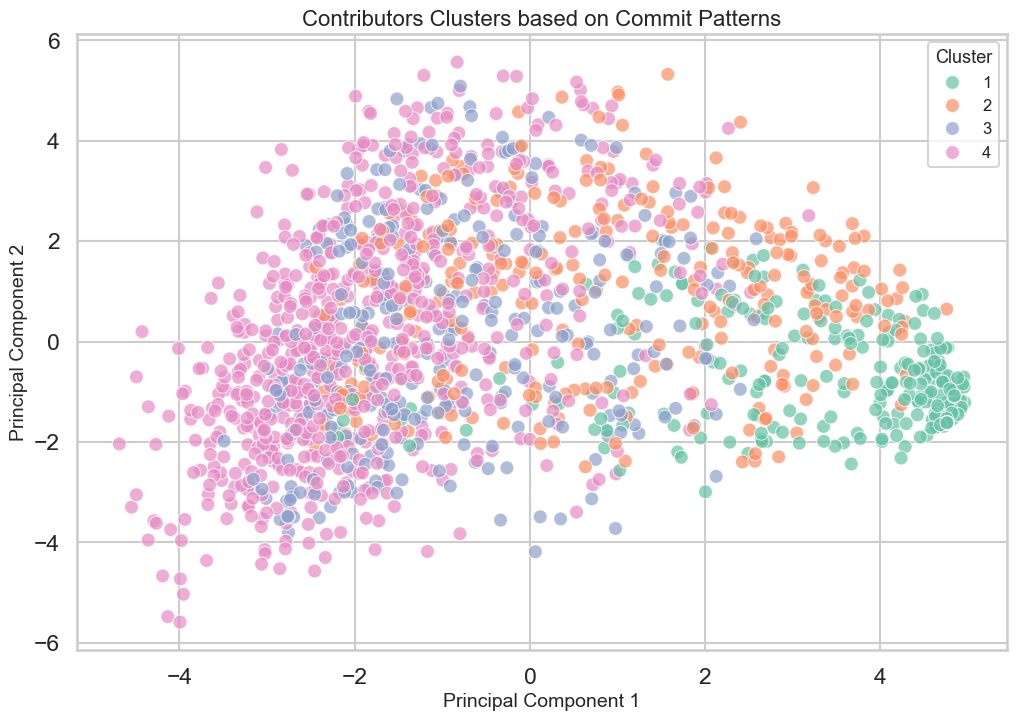


Common Metrics per Cluster:
   Cluster  Total_Commits  Average_Commits_Per_Contributor  \
0        1           8138                        22.418733   
1        2          22972                        79.487889   
2        3          41053                       127.099071   
3        4         263227                       363.071724   

   Average_Commits_Per_Week  Commit_Variance  
0                  0.431129      5363.426388  
1                  1.528613     26253.917388  
2                  2.444213     28131.648540  
3                  6.982149    194665.519710  


In [81]:
import pandas as pd
import numpy as np
from scipy.cluster.hierarchy import fcluster
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# ----------------------------
# Step 1: Assign Cluster Labels
# ----------------------------

# Define the desired number of clusters
num_clusters = 4  # You can adjust this based on your data and analysis

# Assign cluster labels using the linkage matrix from hierarchical clustering
cluster_labels = fcluster(linkage_matrix, num_clusters, criterion='maxclust')

# ----------------------------------------
# Step 2: Prepare Data for Dimensionality Reduction
# ----------------------------------------

# Create a list of contributors and their corresponding commit patterns
contributors = list(series_dict.keys())
commit_patterns = list(series_dict.values())

# Convert the commit patterns into a DataFrame
commit_data = pd.DataFrame(commit_patterns, index=contributors, columns=[f'Week {i+1}' for i in range(len(commit_patterns[0]))])

# Normalize the commit data (same normalization used during clustering)
series_matrix = commit_data.values
series_matrix_normalized = (series_matrix - series_matrix.mean(axis=1, keepdims=True)) / (
    series_matrix.std(axis=1, keepdims=True) + 1e-10
)
commit_data_normalized = pd.DataFrame(
    series_matrix_normalized,
    index=contributors,
    columns=commit_data.columns
)

# ----------------------------------------
# Step 3: Apply PCA for Dimensionality Reduction
# ----------------------------------------

# Initialize PCA to reduce to 2 principal components
pca = PCA(n_components=2)

# Fit PCA on the normalized commit data and transform it
pca_result = pca.fit_transform(commit_data_normalized)

# Create a DataFrame for plotting, including cluster labels
plot_df = pd.DataFrame({
    'Contributor': contributors,
    'PC1': pca_result[:, 0],
    'PC2': pca_result[:, 1],
    'Cluster': cluster_labels
})

# ----------------------------------------
# Step 4: Visualize the Clusters
# ----------------------------------------

plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=plot_df,
    x='PC1',
    y='PC2',
    hue='Cluster',
    palette='Set2',
    s=100,
    alpha=0.7
)
plt.title('Contributors Clusters based on Commit Patterns', fontsize=16)
plt.xlabel('Principal Component 1', fontsize=14)
plt.ylabel('Principal Component 2', fontsize=14)
plt.legend(title='Cluster', fontsize=12, title_fontsize=13)
plt.grid(True)
plt.show()

# ----------------------------------------
# Step 5: Compute Common Metrics per Cluster
# ----------------------------------------

# Add cluster labels to the commit data
commit_data['Cluster'] = cluster_labels

# Calculate Total Commits per Contributor
commit_data['Total_Commits'] = commit_data.iloc[:, :-1].sum(axis=1)  # Exclude 'Cluster' column

# Calculate Average Commits per Week per Contributor
commit_data['Average_Commits_Per_Week'] = commit_data.iloc[:, :-2].mean(axis=1)  # Exclude 'Cluster' and 'Total_Commits'

# Group by Cluster and compute summary statistics
metrics = commit_data.groupby('Cluster').agg(
    Total_Commits=('Total_Commits', 'sum'),
    Average_Commits_Per_Contributor=('Total_Commits', 'mean'),
    Average_Commits_Per_Week=('Average_Commits_Per_Week', 'mean'),
    Commit_Variance=('Total_Commits', 'var')
).reset_index()

# Display the metrics
print("\nCommon Metrics per Cluster:")
print(metrics)


In [82]:
import pandas as pd

# Assuming you have the following DataFrames available:
# - df_all: Original dataset containing 'contributor', 'stability', 'category', 'is_core', etc.
# - commit_data: DataFrame containing 'contributor' and 'Cluster' columns

# Ensure 'contributor' is a column in commit_data
if 'contributor' not in commit_data.columns:
    commit_data = commit_data.reset_index().rename(columns={'index': 'contributor'})

# Merge commit_data with df_all to get 'stability', 'category', and 'is_core'
merged_df = pd.merge(commit_data, df_all[['contributor', 'stability', 'category', 'is_core']], on='contributor', how='left')

# Define the columns of interest
columns_of_interest = ['stability', 'category', 'is_core']

# Group by 'Cluster' and calculate the mode for each column
common_characteristics = merged_df.groupby('Cluster')[columns_of_interest].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else 'N/A')

# Display the results
print("Common Characteristics per Cluster:")
print(common_characteristics)


Common Characteristics per Cluster:
        stability category  is_core
Cluster                            
1        UNSTABLE   OSS4SG     True
2          STABLE   OSS4SG     True
3          STABLE   OSS4SG     True
4          STABLE   OSS4SG     True


In [ ]:
that the way we did a normalization not perfrect also we need to make our data mroe palanced.